# Prediction the cost of cars

The car sales service is developing an application to attract new customers. It allows you to quickly find out the market value of your car. You need to build a model to determine the cost. 

## Data preparation

### Installing and importing the necessary libraries

In [9]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import phik
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo

from phik import report
from phik.report import plot_correlation_matrix
from plotly.offline import download_plotlyjs
from plotly.offline import init_notebook_mode
from plotly.offline import iplot
from plotly.offline import plot

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

pyo.init_notebook_mode()
init_notebook_mode(connected=True)

### Reading the data and writing it to variables

Let's print the first 5 lines

In [11]:
df.head()

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0   golf     150000                  0    petrol  volkswagen      NaN   
1    NaN     125000                  5  gasoline        audi      yes   
2  grand     125000                  8  gasoline        jeep      NaN   
3   golf     150000                  6    petrol  volkswagen       no   
4  fabia      90000                  7  gasoline       skoda       no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00:00:00                 0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                 0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                 0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00                 0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00                 0       60437  2016-04-06 10:17:21

We will display general information about the date and time

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Let's print the number of gaps in each column

In [13]:
df.shape[0] - df.count()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Let's print the number of passes as a percentage

In [14]:
((df.shape[0] - df.count()) / df.shape[0] * 100).sort_values(ascending=False)

Repaired             20.079070
VehicleType          10.579368
FuelType              9.282697
Gearbox               5.596709
Model                 5.560588
DateCrawled           0.000000
Price                 0.000000
RegistrationYear      0.000000
Power                 0.000000
Kilometer             0.000000
RegistrationMonth     0.000000
Brand                 0.000000
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

Omissions were found in 5 columns. The highest percentage of omissions in the repaired column is about 20%

### Let's change the data type to time series in columns DateCrawled, DateCreated, LastSeen

In [15]:
for i in ['DateCrawled', 'DateCreated', 'LastSeen']:
    df[i] = pd.to_datetime(df[i])

### Let's display histograms for each feature

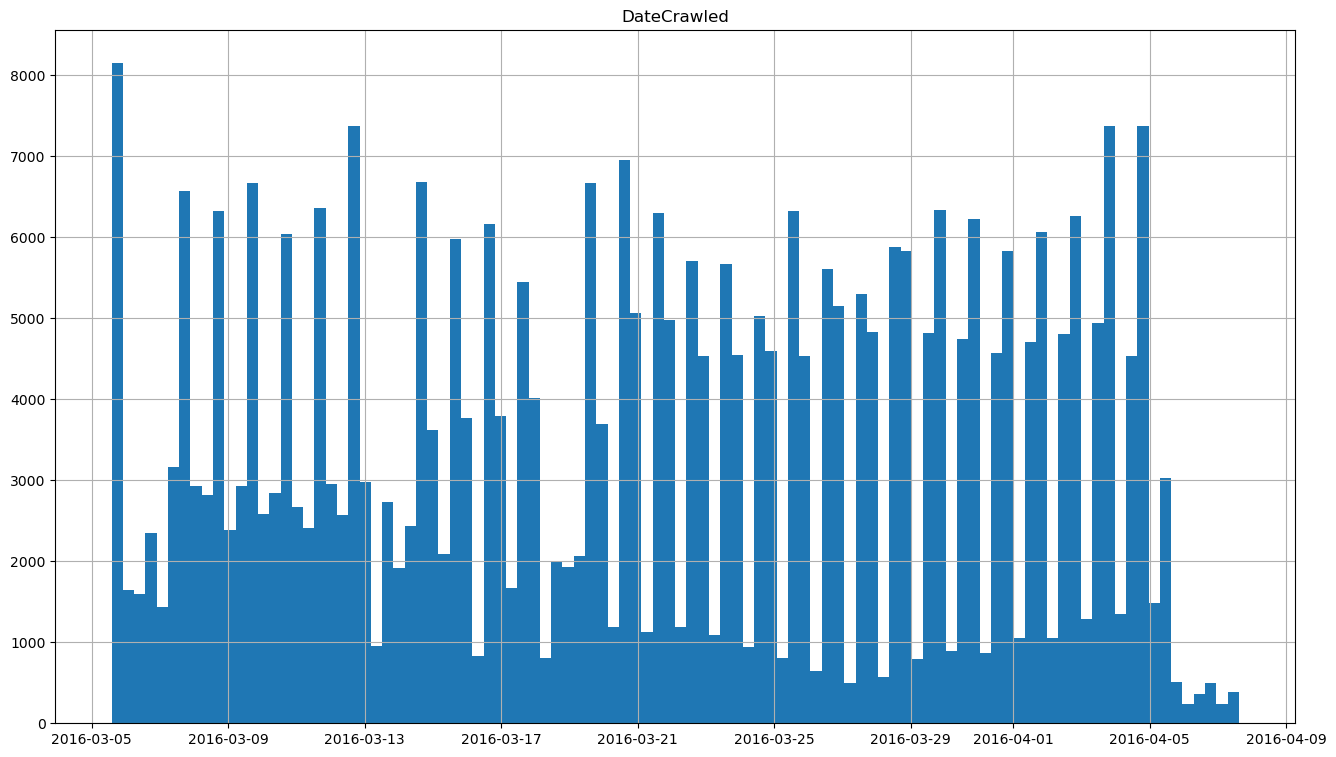

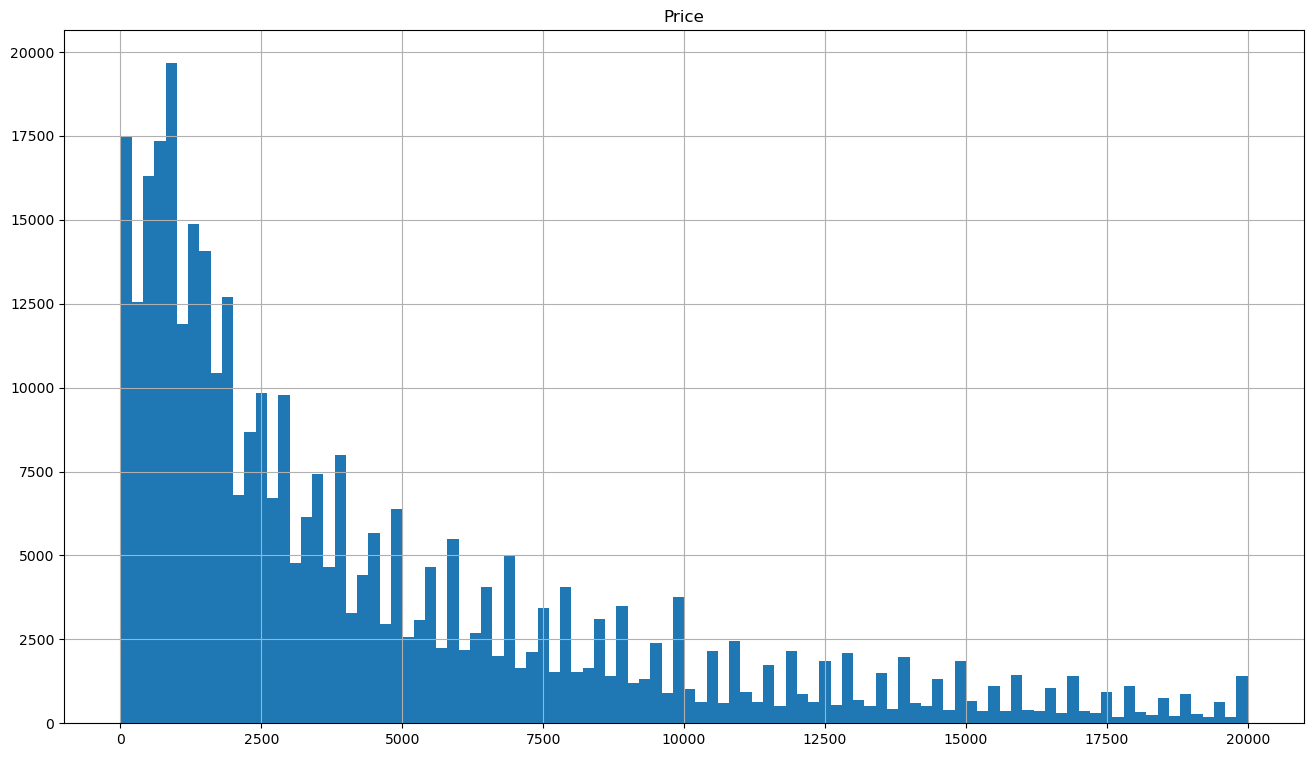

Необходимо построить барплот для фичи  VehicleType


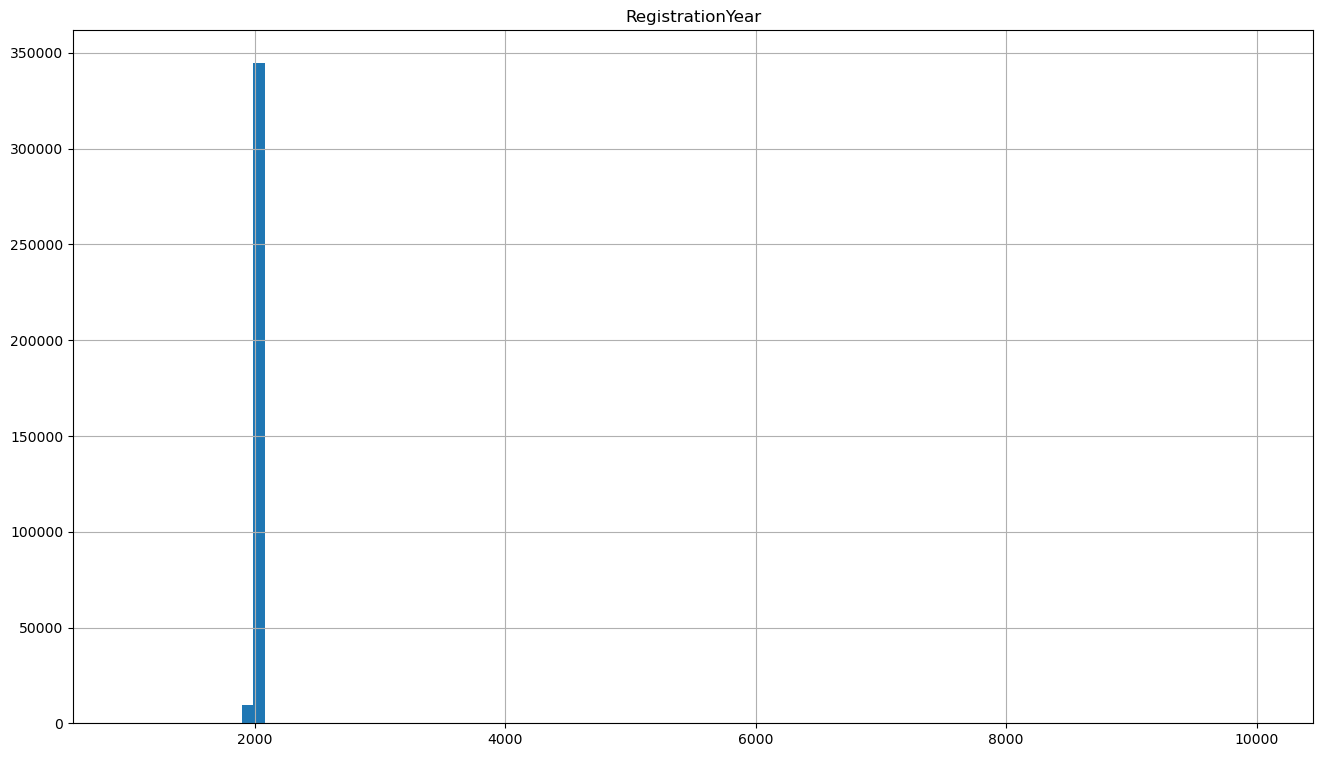

Необходимо построить барплот для фичи  Gearbox


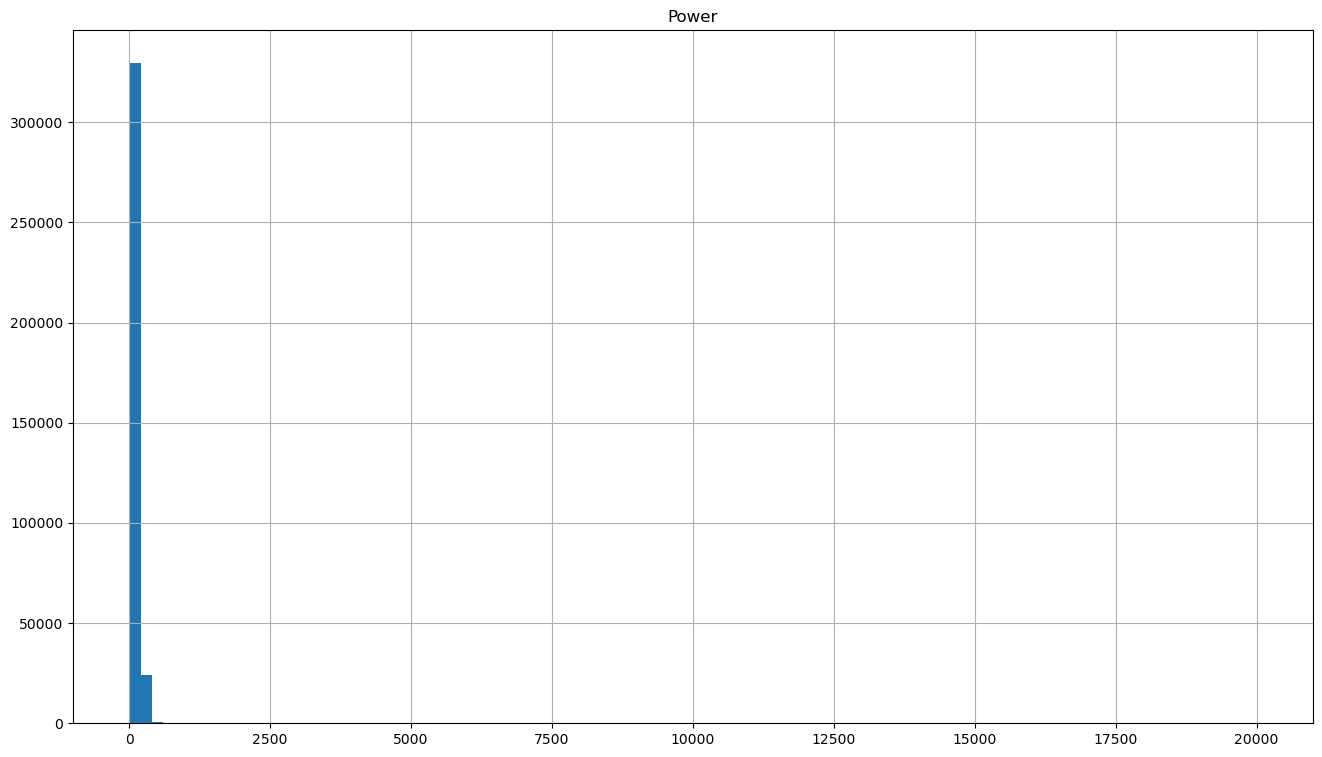

Необходимо построить барплот для фичи  Model


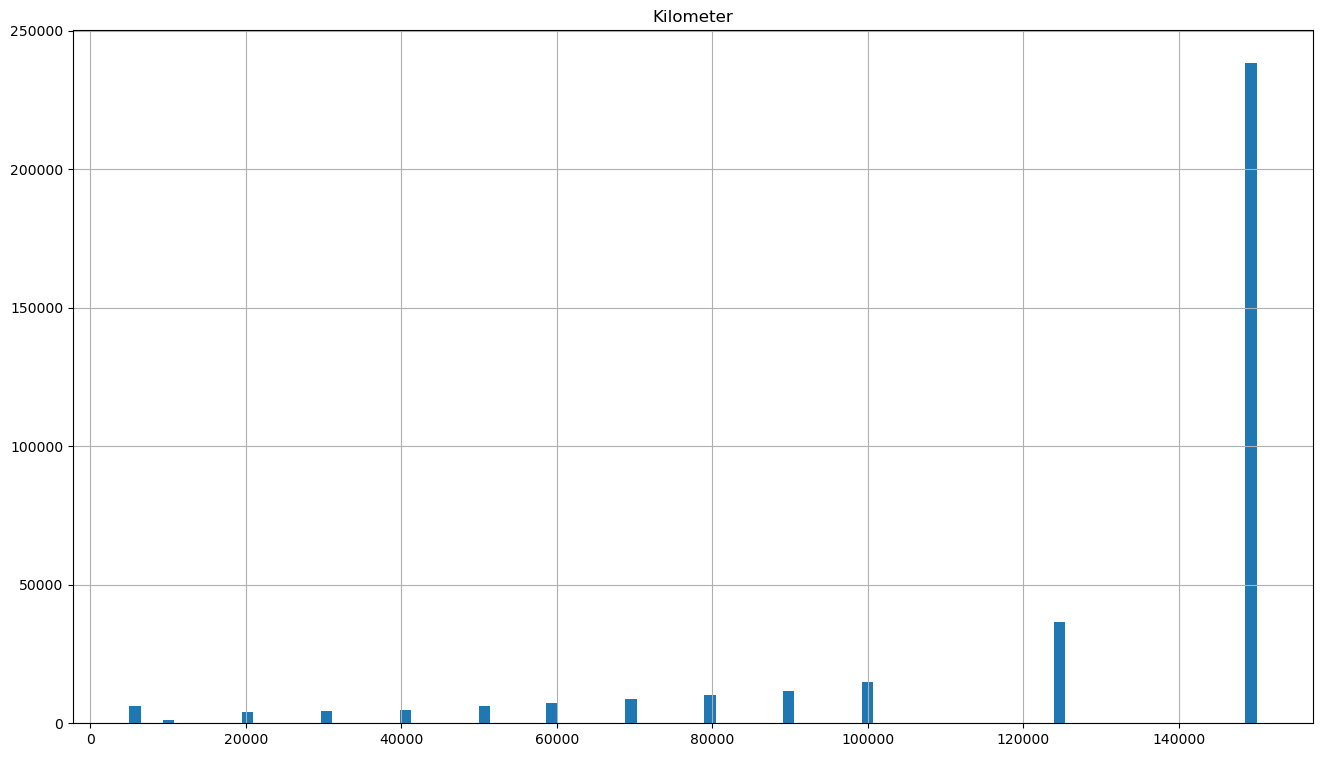

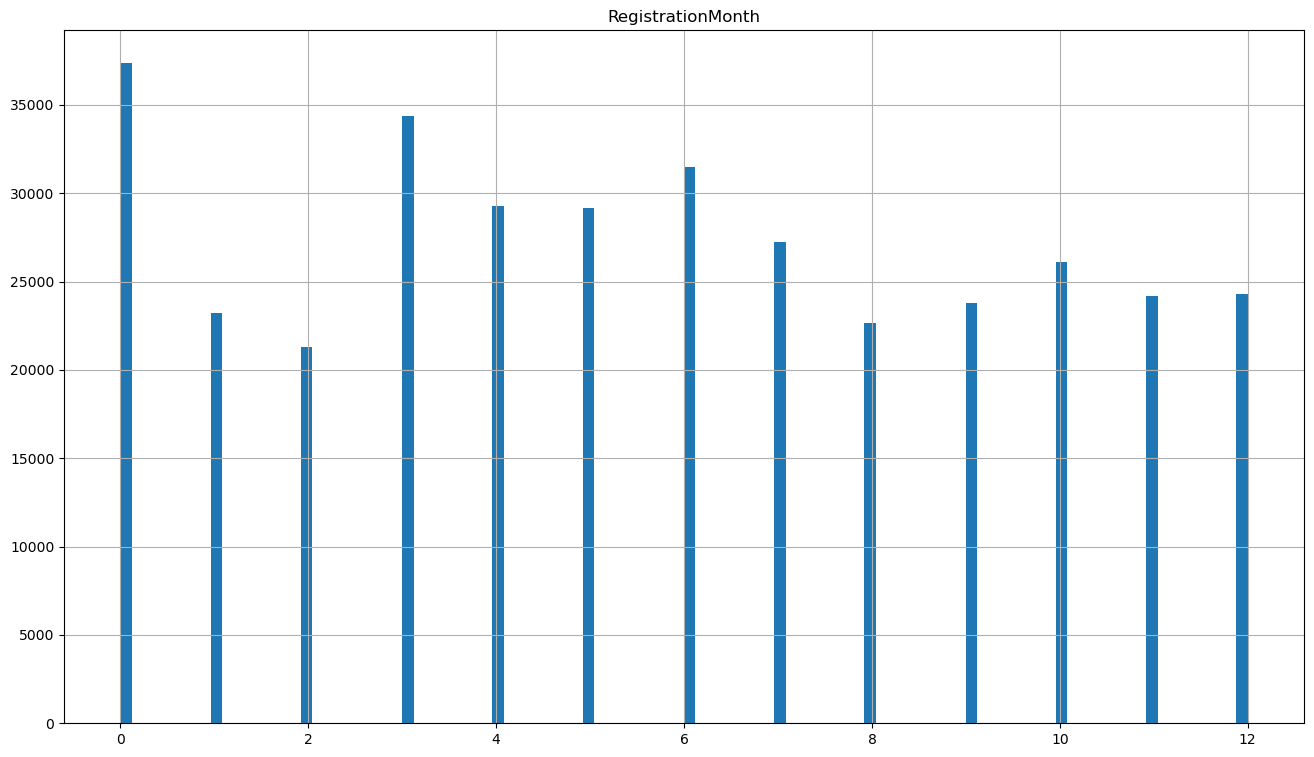

Необходимо построить барплот для фичи  FuelType
Необходимо построить барплот для фичи  Brand
Необходимо построить барплот для фичи  Repaired


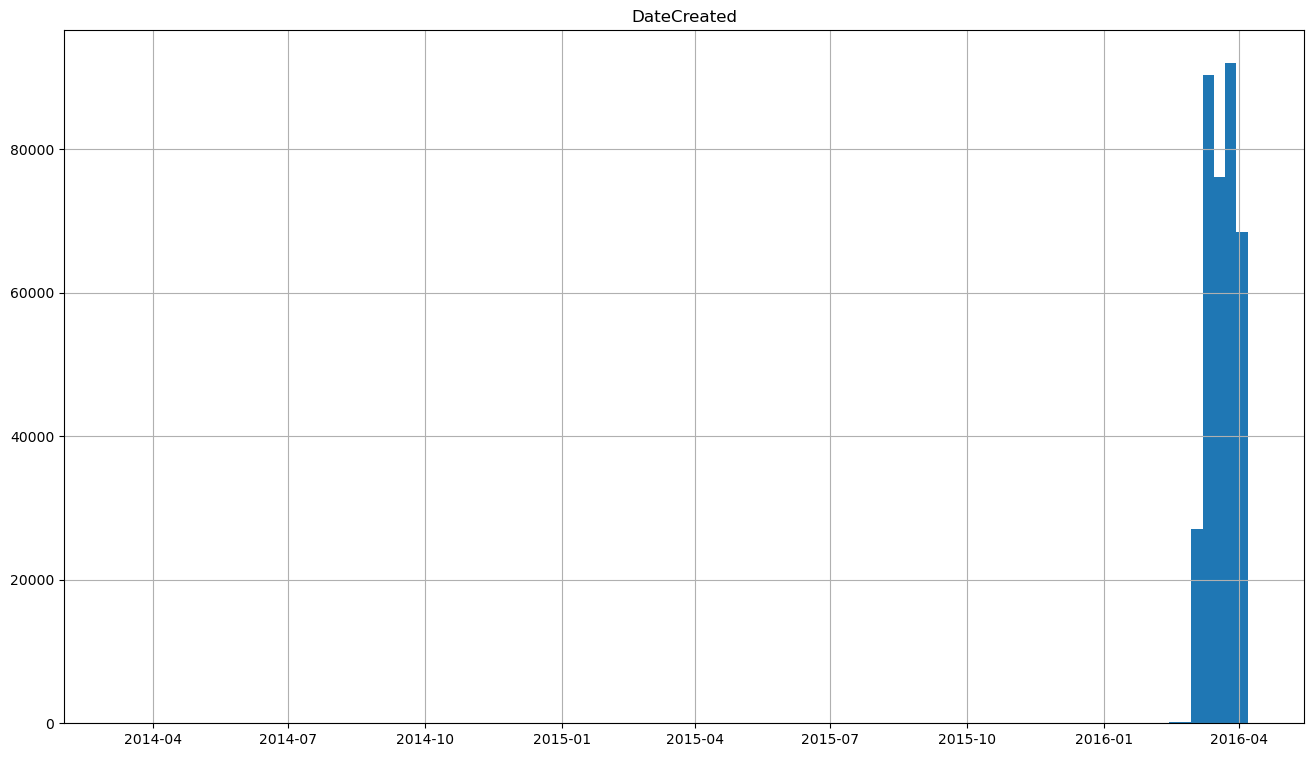

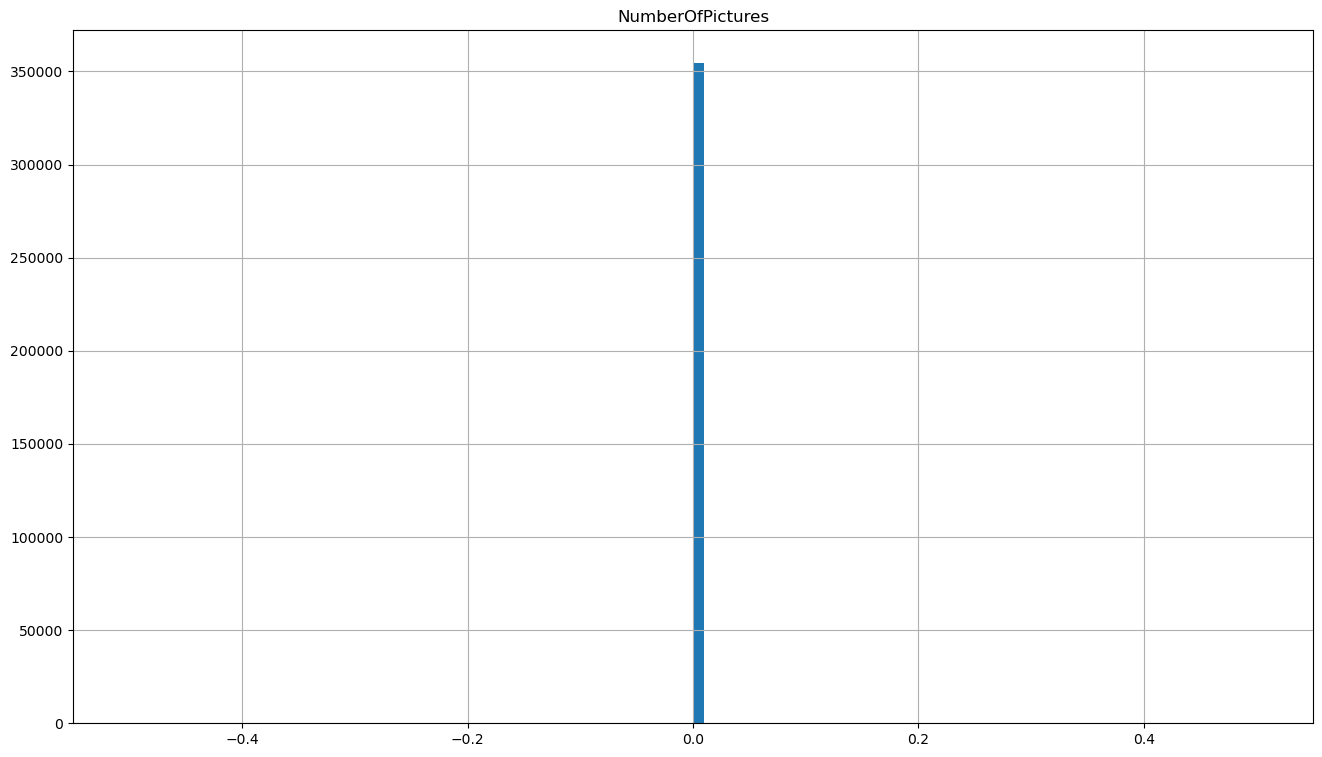

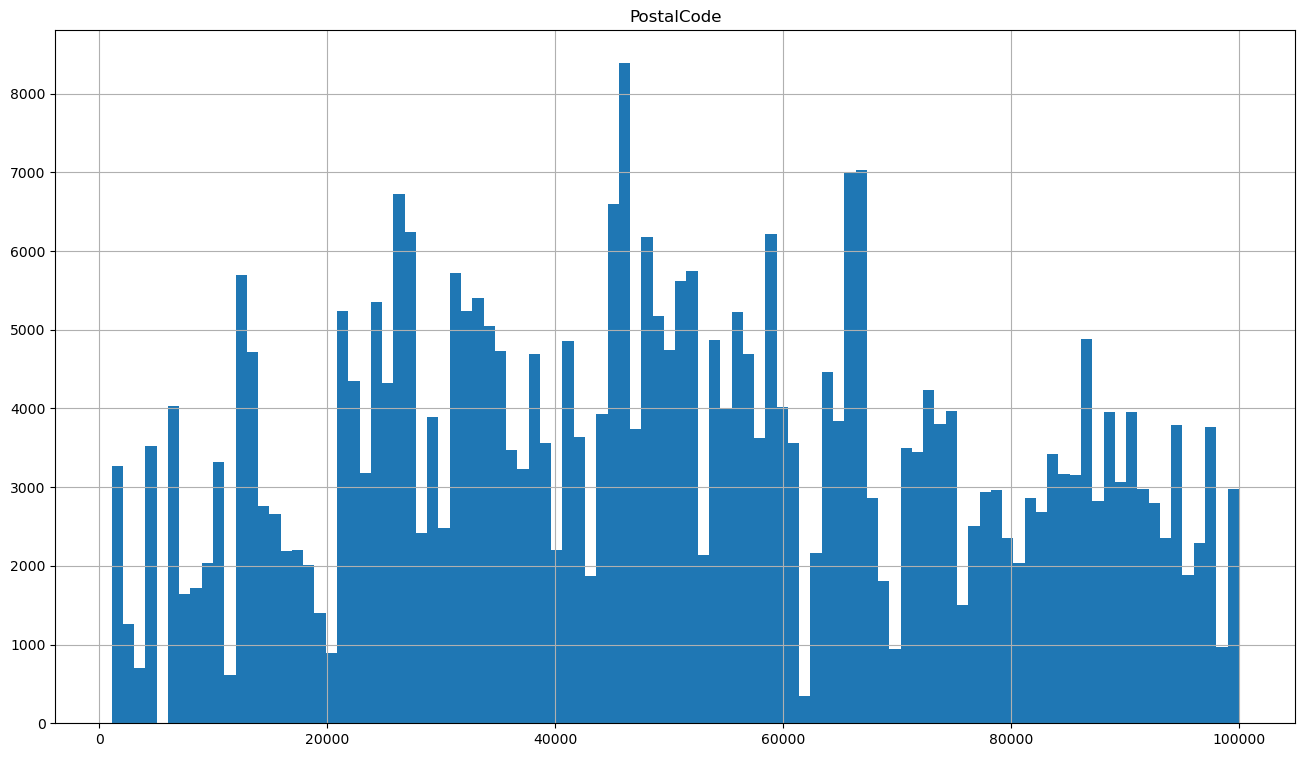

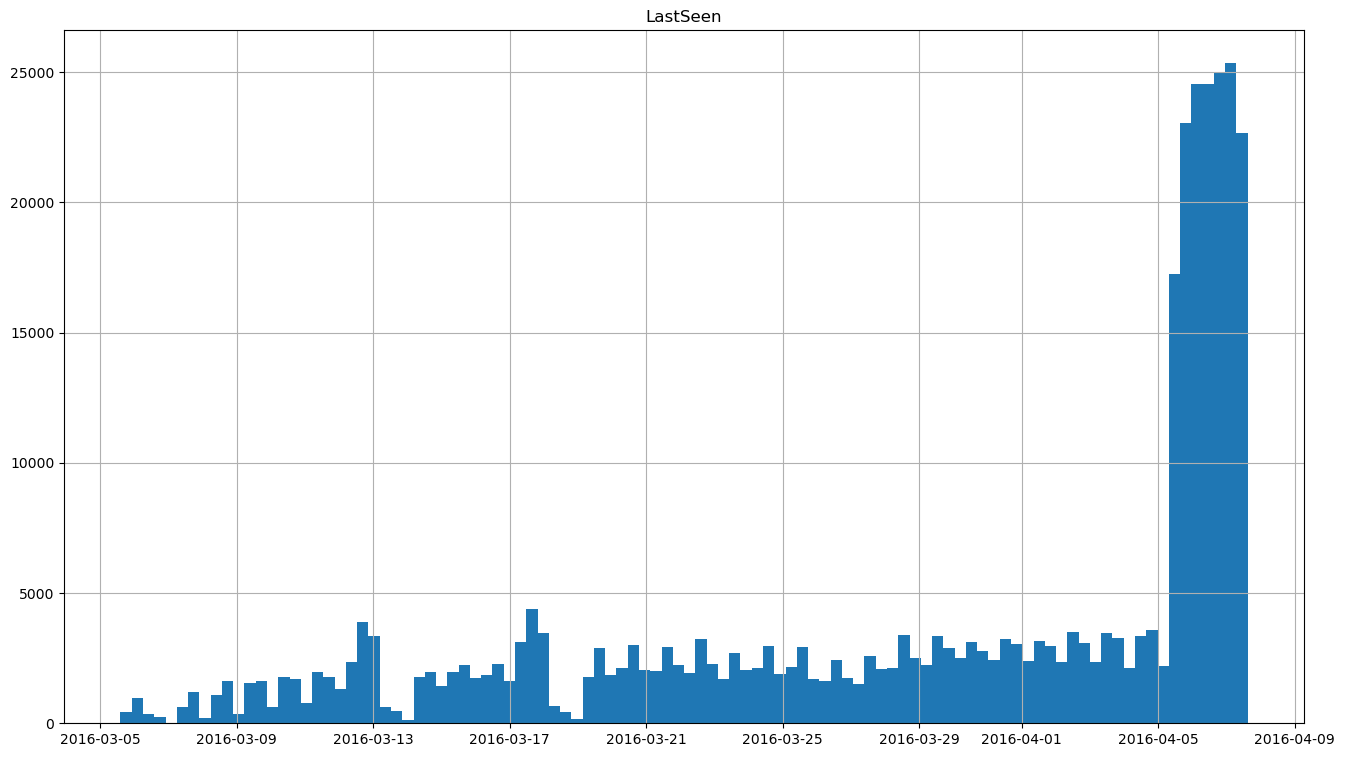

In [16]:
list_for_bar_plot = []
for i in df.columns:
    try:
        df.hist(column=i, figsize=(16,9), bins=100)
        plt.show()
    except:
        list_for_bar_plot.append(i)
        print("Необходимо построить барплот для фичи ", i)

### Price Target Analysis

We see that there are quite a lot of zero values in the target indicator. Obviously, there is no point in filling it out somehow. I think that such data should be deleted from the dataframe

In [17]:
df[df['Price'] == 0]

DateCrawled  Price VehicleType  RegistrationYear Gearbox  \
7      2016-03-21 18:54:38      0       sedan              1980  manual   
40     2016-03-26 22:06:17      0         NaN              1990     NaN   
111    2016-03-19 18:40:12      0         NaN              2017  manual   
115    2016-03-20 18:53:27      0       small              1999     NaN   
152    2016-03-11 18:55:53      0         bus              2004  manual   
...                    ...    ...         ...               ...     ...   
354205 2016-03-09 15:56:30      0         NaN              2000  manual   
354238 2016-03-20 14:55:07      0       small              2002  manual   
354248 2016-03-24 13:48:05      0       small              1999  manual   
354277 2016-03-10 22:55:50      0       small              1999  manual   
354364 2016-03-21 09:50:58      0         NaN              2005  manual   

        Power   Model  Kilometer  RegistrationMonth FuelType       Brand  \
7          50   other      40000                  7   petrol  volkswagen   
40          0   corsa     150000                  1   petrol        opel   
111         0    golf       5000                 12   petrol  volkswagen   
115         0     NaN       5000                  0   petrol  volkswagen   
152       101  meriva     150000                 10      lpg        opel   
...       ...     ...        ...                ...      ...         ...   
354205     65   corsa     150000                  0      NaN        opel   
354238     60  fiesta     150000                  3   petrol        ford   
354248     53   swift     150000                  3   petrol      suzuki   
354277     37   arosa     150000                  7   petrol        seat   
354364      0    colt     150000                  7   petrol  mitsubishi   

       Repaired DateCreated  NumberOfPictures  PostalCode            LastSeen  
7            no  2016-03-21                 0       19348 2016-03-25 16:47:58  
40          NaN  2016-03-26                 0       56412 2016-03-27 17:43:34  
111         NaN  2016-03-19                 0       21698 2016-04-01 08:47:05  
115         NaN  2016-03-20                 0       37520 2016-04-07 02:45:22  
152         yes  2016-03-11                 0       27432 2016-03-12 23:47:10  
...         ...         ...               ...         ...                 ...  
354205      yes  2016-03-09                 0       23758 2016-03-30 11:16:08  
354238      NaN  2016-03-20                 0       33659 2016-04-06 18:45:23  
354248      NaN  2016-03-24                 0       42329 2016-04-07 05:17:24  
354277      yes  2016-03-10                 0       22559 2016-03-12 23:46:32  
354364      yes  2016-03-21                 0        2694 2016-03-21 10:42:49  

[10772 rows x 16 columns]

In [18]:
df['Price'].value_counts().head(10)

0       10772
500      5670
1500     5394
1000     4649
1200     4594
2500     4438
600      3819
3500     3792
800      3784
2000     3431
Name: Price, dtype: int64

I deleted one percent of the maximum and minimum values each

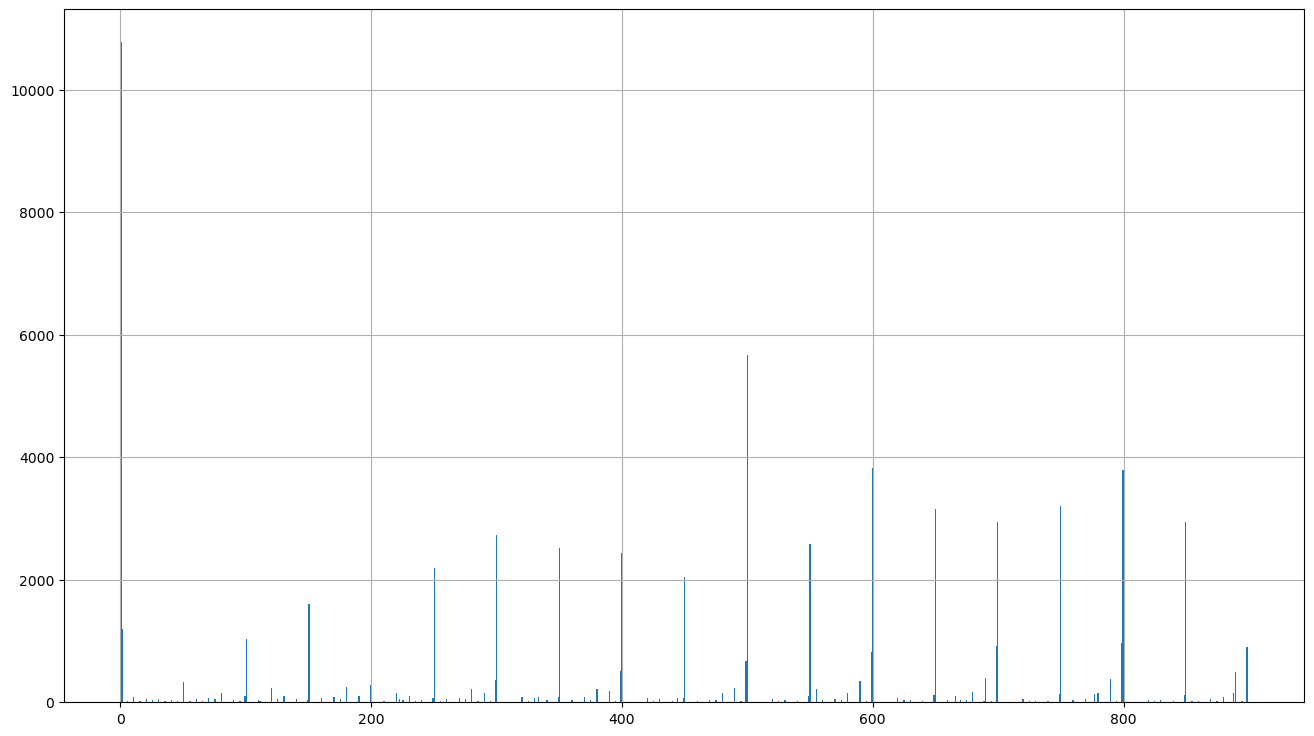

In [19]:
df[df['Price'] < 900]['Price'].hist(bins=900, figsize=(16, 9))
plt.show()

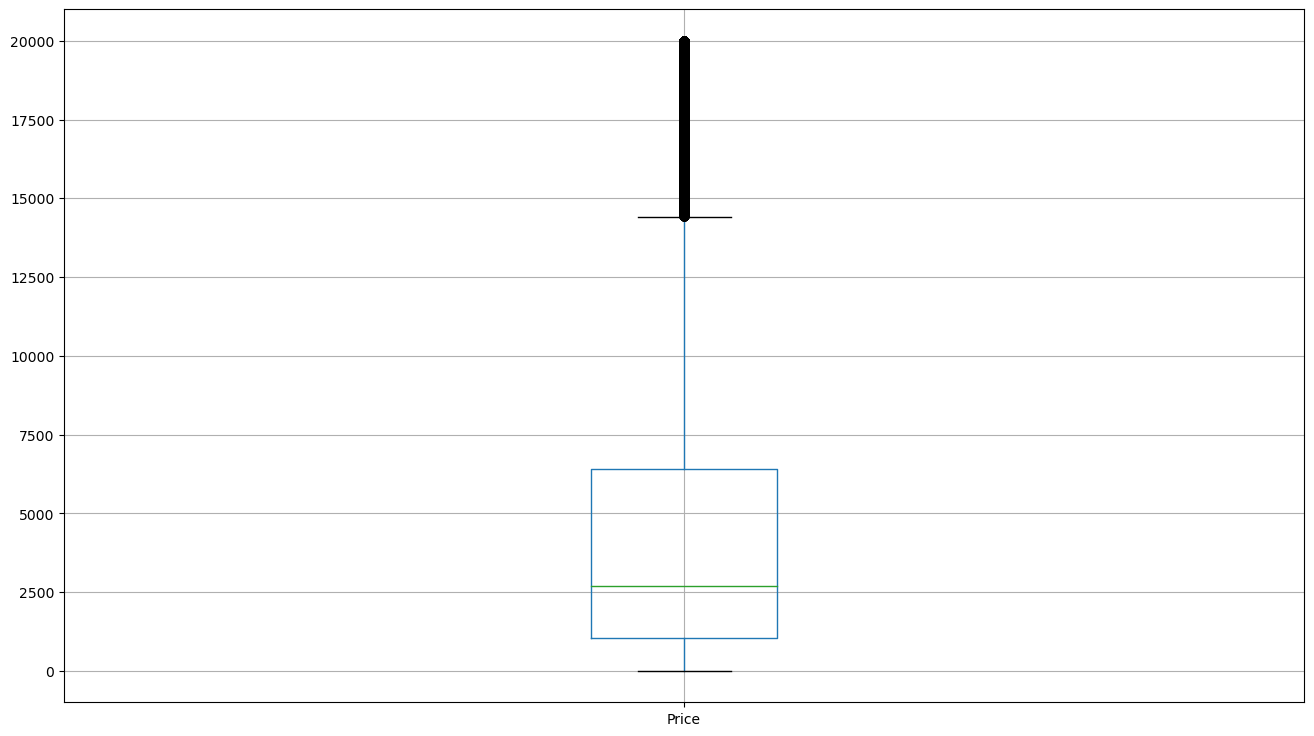

In [20]:
df.boxplot(column='Price', rot=0, grid=True, figsize=(16, 9))
plt.show()

It is difficult to determine extreme data from the distribution, especially those close to zero. I decided to delete one percent of the minimum and maximum values each

In [21]:
q_1 = df[df['Price'] > 0]['Price'].quantile(q=0.01)
q_1

100.0

In [22]:
q_99 = df[df['Price'] > 0]['Price'].quantile(q=0.99)
q_99

18850.0

In [23]:
df = df[(df['Price'] > q_1) & (df['Price'] < q_99)]

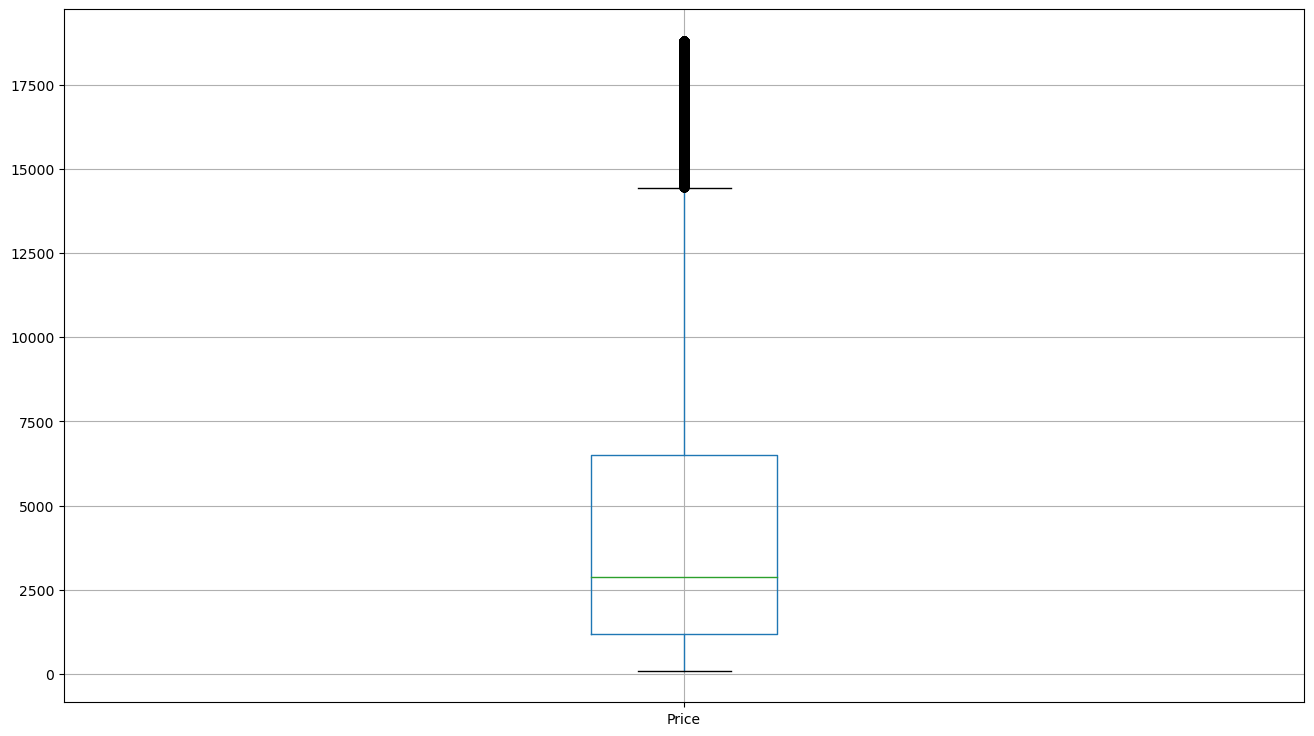

In [24]:
df.boxplot(column='Price', rot=0, grid=True, figsize=(16, 9))
plt.show()

### Let's check the data for the NumberOfPictures column

In [25]:
df['NumberOfPictures'].value_counts()

0    336580
Name: NumberOfPictures, dtype: int64

There are only zeros in the column. Let's delete this column

In [26]:
df = df.drop('NumberOfPictures', axis=1)

### Analyzing the data in the RegistrationMonth column

According to the histogram above, it was noticed that the values are not 12, but 13. Additionally, there are zero values that are illogical. Let's look at the percentage of such data

In [27]:
df['RegistrationMonth'].value_counts(normalize=True).sort_index() * 100

0     9.246539
1     6.590707
2     6.090083
3     9.885614
4     8.369184
5     8.326401
6     9.011231
7     7.792501
8     6.469487
9     6.826906
10    7.498069
11    6.939806
12    6.953473
Name: RegistrationMonth, dtype: float64

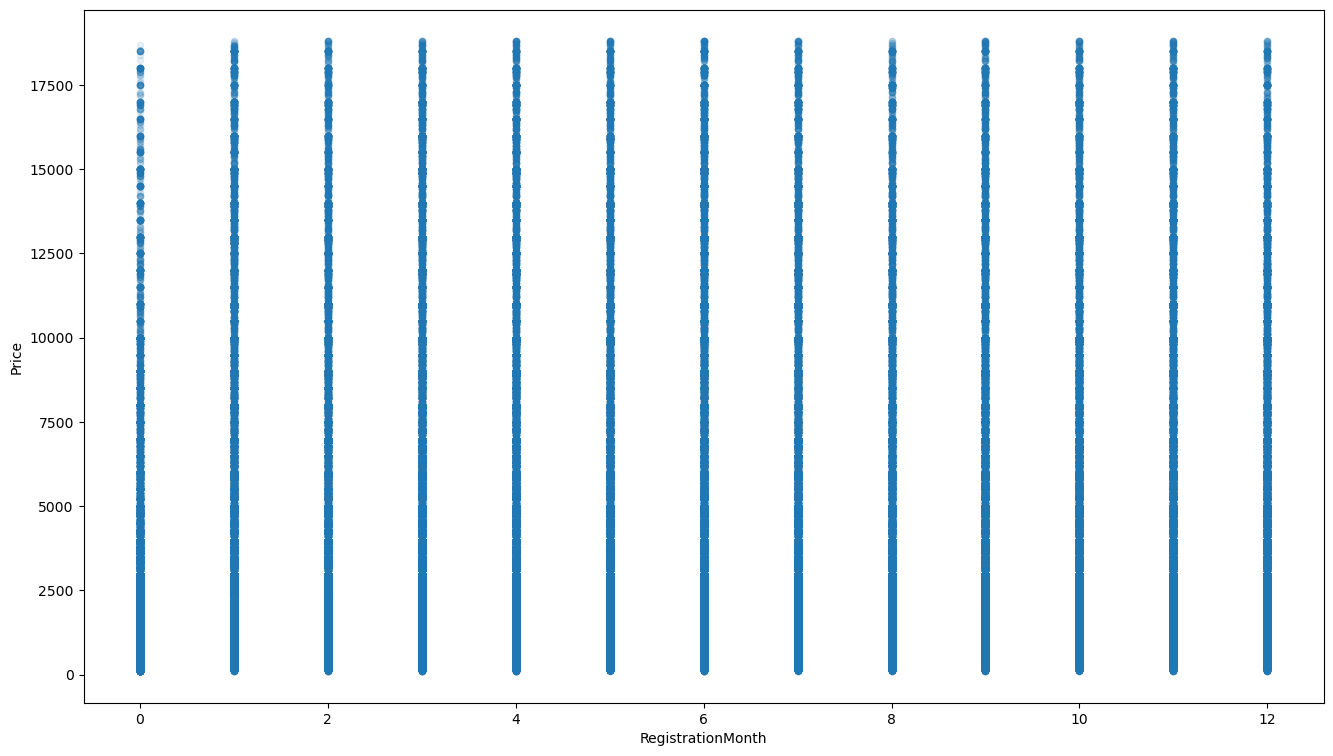

In [28]:
df.plot(kind='scatter', x='RegistrationMonth', y='Price', alpha=0.1, figsize=(16, 9))
plt.show()

At the same time, we see that the data where the month is zero is about 9.9%. This is more than the data in any other month. At the same time, the scatter graph shows that the density of points decreases with an increase in price if the month is 0. I can hypothesize that zeros are the absence of data in this column due to the fact that the owners did not enter information. Consequently, owners who enter information about the month of registration tend to rate their car more expensive. In this case, I can create a new column to replace the month of registration. The new column will characterize whether the owner has entered information about the month of registration

In [29]:
df['RegistrationMonthIs'] = 1

In [30]:
df.loc[df['RegistrationMonth'] == 0, 'RegistrationMonthIs'] = 0

Let's delete the original column with the month of registration

In [31]:
df = df.drop('RegistrationMonth', axis=1)

In [32]:
((df.shape[0] - df.count()) / df.shape[0] * 100).sort_values(ascending=False)

Repaired               18.909620
VehicleType             9.553152
FuelType                8.289560
Model                   4.975043
Gearbox                 4.762612
DateCrawled             0.000000
Price                   0.000000
RegistrationYear        0.000000
Power                   0.000000
Kilometer               0.000000
Brand                   0.000000
DateCreated             0.000000
PostalCode              0.000000
LastSeen                0.000000
RegistrationMonthIs     0.000000
dtype: float64

Let's check on the boxplot

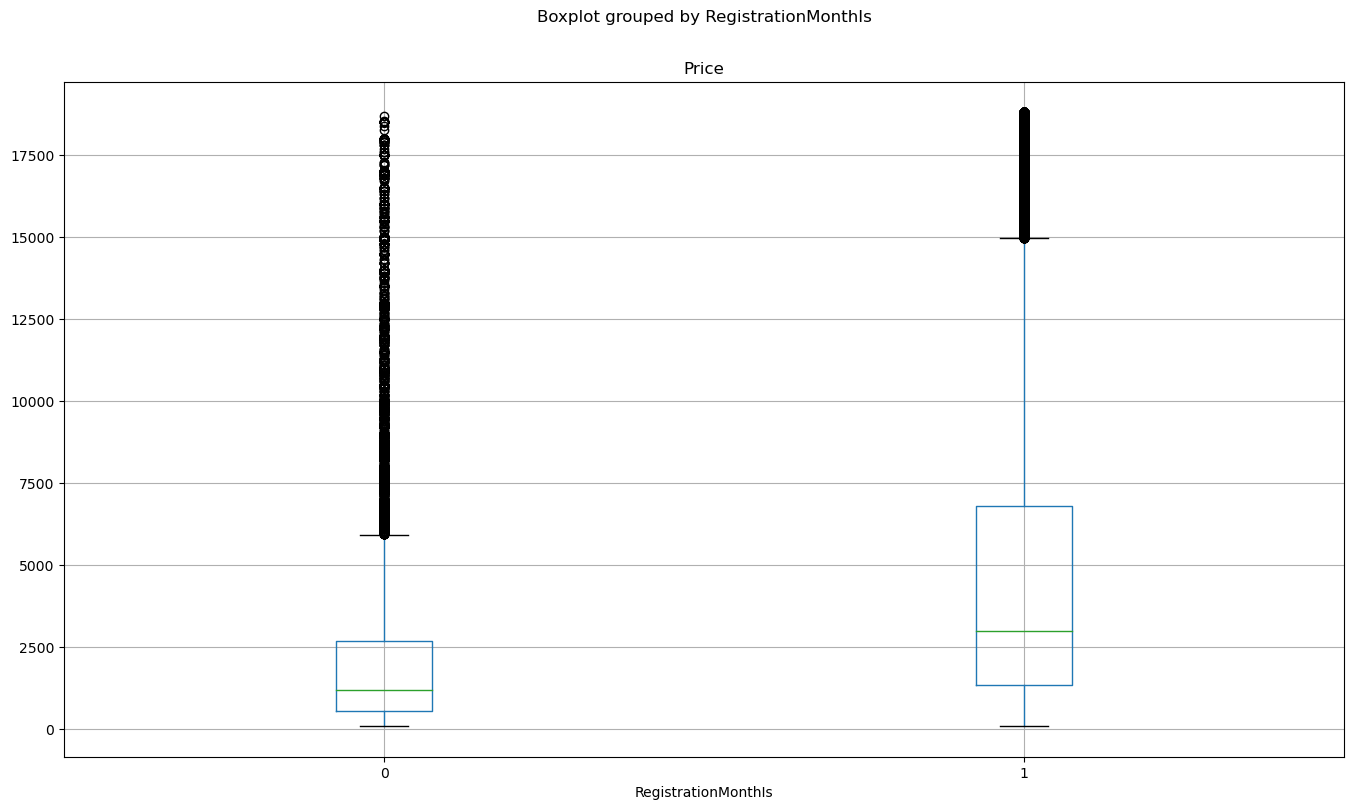

In [33]:
df.boxplot(column='Price', by='RegistrationMonthIs', rot=0, grid=True, figsize=(16, 9))
plt.show()

Obviously, there is a difference

### Analyzing data from date columns: DateCrawled, DateCreated, LastSeen, RegistrationYear, RegistrationMonth

According to the task, the model will be used on data from future periods. In this case, it is worth considering the appropriateness of using the following parameters in the model:

* **DateCrawled** - date the questionnaire was downloaded from the database. The values in this column change only in the range from March to April 2016. I believe that the use of this characteristic is inappropriate for the following reasons:
    * A narrow date range. Even if you select only months, these are only two values: March and April;
    * I believe that the date of data upload does not affect the cost of the car in any way.
* **DateCreated** - the date of creation of the questionnaire is limited to the same period as DateCrawled. For this reason, I consider it inappropriate to use it for future periods
* **lastSeen** - also limited to a period of just over a month. I think it is impossible to extract useful information from this data that would improve the model
* **RegistrationYear, RegistrationMonth** - I assume that the cost of the car may really depend on the year of registration. Let's leave this feature, although it will need to be worked on well to ensure that it works in the future. For example, combine the month of registration with the feature and calculate how many years or months ago the car was registered.

Let's delete this data from the dataframe

In [34]:
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)

### Analyzing the data in the PostalCode column

According to the previous graphs, there are quite a lot of unique values. Let's output the 10 most frequent ones and check the exact number of unique indexes

In [35]:
df['PostalCode'].value_counts().sort_values(ascending=False).head(10)

10115    786
65428    593
66333    319
44145    299
32257    296
52525    291
78224    280
13357    280
26789    276
48599    276
Name: PostalCode, dtype: int64

In [36]:
len(df['PostalCode'].unique())

8135

Checking on the website https://www.postalcodesdb.com/Search.aspx the first two indexes, it became clear that one index can point to several different locations on the map. If we assume that we are doing a service only for evaluating Russian cars, then this assumption does not work for the first index 10115, since judging by the database there is no such index in Russia (I found my index at the same time, which suggests that there are Russian indices in this database in principle). In total, I decided not to use this parameter for the model due to the fact that it is a "random" number that can indicate several localities at once. I don't see any point in bothering with him yet. Just delete it.

In [37]:
df = df.drop('PostalCode', axis=1)

### Let's check the data in the RegistrationYear column, since there are obvious outliers in it

In [38]:
df['RegistrationYear'].value_counts().sort_index().head(50)

1000     22
1001      1
1039      1
1111      1
1234      3
1300      2
1400      1
1500      2
1600      2
1602      1
1800      4
1910     34
1923      2
1925      1
1927      1
1928      2
1929      5
1930      2
1931      1
1932      2
1933      1
1934      2
1935      3
1936      2
1937     10
1938      8
1940      2
1941      2
1942      2
1943      3
1944      2
1945      4
1946      1
1947      2
1948      2
1949      1
1950     13
1951      9
1952      7
1953     14
1954      9
1955     10
1956     24
1957     13
1958     19
1959     29
1960    115
1961     34
1962     38
1963     48
Name: RegistrationYear, dtype: int64

Judging by the columns with the dates LastSeen and DateCreated and DateCrawled, this dataframe contains data up to April 2016. Let's try to determine emissions by pre-selecting only those data that do not fall within the range from 1950 to 2016. 1950 is chosen because in the sample in the cell above we see that from this year an increase in the number of registered cars begins compared to previous ones

In [39]:
df_incorrect_year = df[(df['RegistrationYear'] > 2016) | (df['RegistrationYear'] < 1950)]
df_incorrect_year

Price VehicleType  RegistrationYear Gearbox  Power    Model  \
15        450       small              1910     NaN      0       ka   
22       2900         NaN              2018  manual     90   meriva   
26       5555         NaN              2017  manual    125       c4   
48       7750         NaN              2017  manual     80     golf   
51       2000         NaN              2017  manual     90    punto   
...       ...         ...               ...     ...    ...      ...   
354112   3600         NaN              2017  manual     86  transit   
354140   1000         NaN              2017  manual    101       a4   
354203   2140         NaN              2018  manual     80   fiesta   
354253   1250         NaN              2018     NaN      0    corsa   
354289   5000         NaN              2017  manual    120    other   

        Kilometer  FuelType       Brand Repaired  RegistrationMonthIs  
15           5000    petrol        ford      NaN                    0  
22         150000    petrol        opel       no                    1  
26         125000       NaN     citroen       no                    1  
48         100000    petrol  volkswagen      NaN                    1  
51         150000  gasoline        fiat      yes                    1  
...           ...       ...         ...      ...                  ...  
354112     150000  gasoline        ford      NaN                    1  
354140     150000       NaN        audi      NaN                    1  
354203     150000       NaN        ford       no                    1  
354253     150000    petrol        opel      NaN                    0  
354289     150000       NaN     citroen      yes                    1  

[13762 rows x 11 columns]

We see that the values in the VehicleType column are missing almost everywhere in this data. Let's output the size of the entire received dataframe

In [40]:
shape_df_incorrect_year = df_incorrect_year.shape
shape_df_incorrect_year

(13762, 11)

Output the size of the dataframe, with the missing values in the VehicleType column

In [41]:
shape_df_incorrect_year_mis_values = df_incorrect_year[df_incorrect_year['VehicleType'].isna()].shape
shape_df_incorrect_year_mis_values

(13671, 11)

Output the percentage of missing data in the VehicleType column in the resulting dataframe

In [42]:
shape_df_incorrect_year_mis_values[0] / shape_df_incorrect_year[0] * 100

99.33875890132248

In 99% of cases, data is missing. In this case, it is best to delete the data from the dataframe

In [43]:
df.shape

(336580, 11)

In [44]:
df = df.drop(df_incorrect_year.index, axis=0)
df.shape

(322818, 11)

In this case, it seemed to me that it was better to do something different than with the data in the other columns with gaps, where I filled in the gaps with unknown values. The first reason is that all other data is categorical with the object data type. I didn't want to interfere in this case with the int with the object. And it would be strange to fill the year with averages or medians. Secondly, I thought that if almost all the rows with this data have missing data in another column, then their value decreases. 
In total, taking into account what I wrote above, as well as taking into account your comments, I decided to use two approaches in dealing with omissions and anomalies. Categorical ones should be filled with unknown values, and numeric ones should be deleted

Let's print the number of passes as a percentage

In [45]:
((df.shape[0] - df.count()) / df.shape[0] * 100).sort_values(ascending=False)

Repaired               17.870131
FuelType                7.019125
VehicleType             5.725517
Model                   4.601354
Gearbox                 4.426333
Price                   0.000000
RegistrationYear        0.000000
Power                   0.000000
Kilometer               0.000000
Brand                   0.000000
RegistrationMonthIs     0.000000
dtype: float64

### Converting the RegistrationYear column

By converting, I mean the replacement of the year of registration of the car with the "prescription" of registration. Since the cost of a car clearly varies depending rather not on the year, as a categorical variable, but on the prescription (after a year the car will become older, respectively cheaper). And since I understand from the data with dates that this table is relevant for 2016, I will take this year as the zero mark. But if there was a real task of implementing this model into work, then it would be possible to make the current year automatically set for calculation. I don't see any point in wasting time on this right now.

In [46]:
df['RegistrationYearsAgo'] = 2016 - df['RegistrationYear']

In [47]:
df = df.drop('RegistrationYear', axis=1)

### After deleting the data with dates, we will build a correlation matrix using the pil library without taking into account data gaps

In [48]:
phik_overview = df.dropna().phik_matrix()
phik_overview.round(2)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 8))
plt.tight_layout()

interval columns not set, guessing: ['Price', 'Power', 'Kilometer', 'RegistrationMonthIs', 'RegistrationYearsAgo']


We see that Model correlates with Brand and VehicleType

### Let's fill in the missing data in the categorical features on unknown

In [49]:
for i in ['Repaired', 'VehicleType', 'Model', 'FuelType', 'Gearbox']:
    df[i] = df[i].fillna('unknown')

### By filling in all the data with plugs, I can plot the spread of the target's dependence on each feature

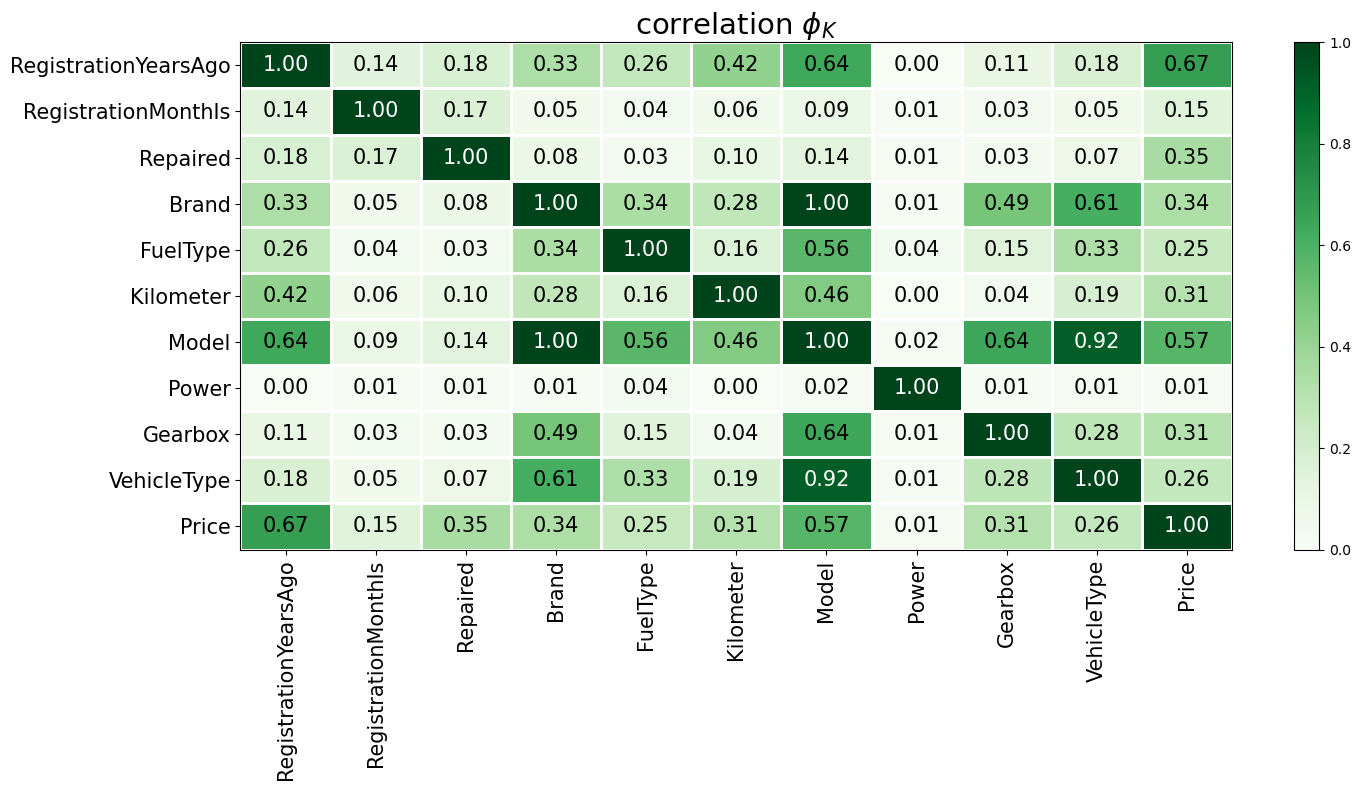

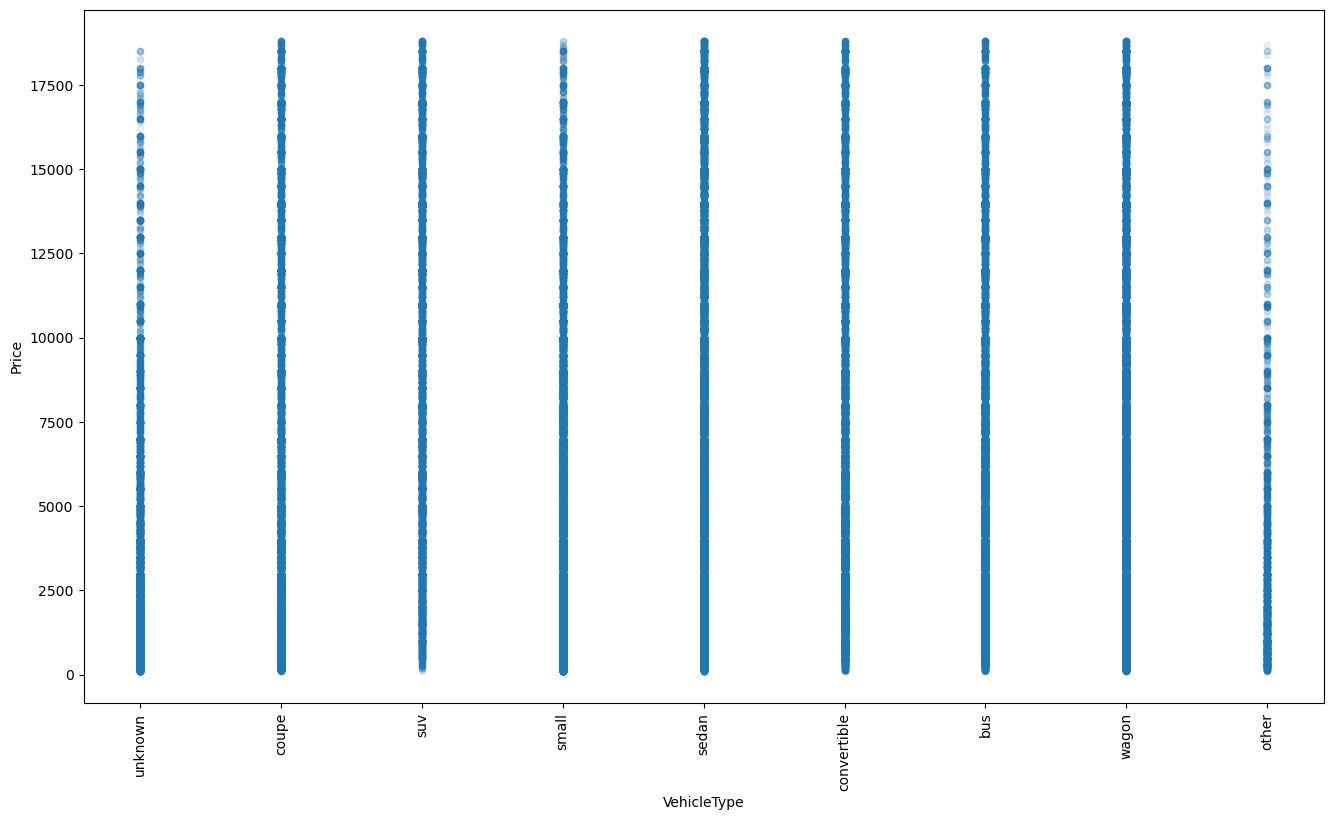

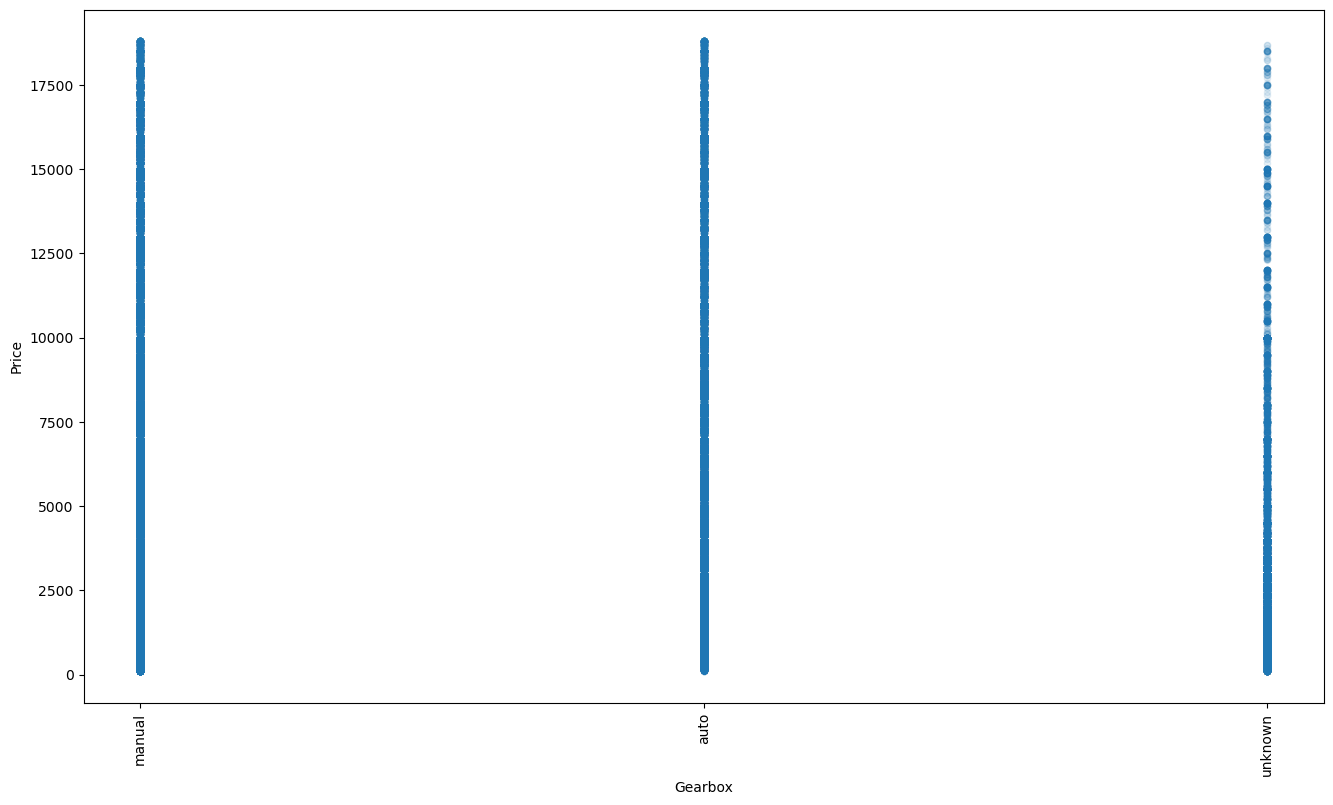

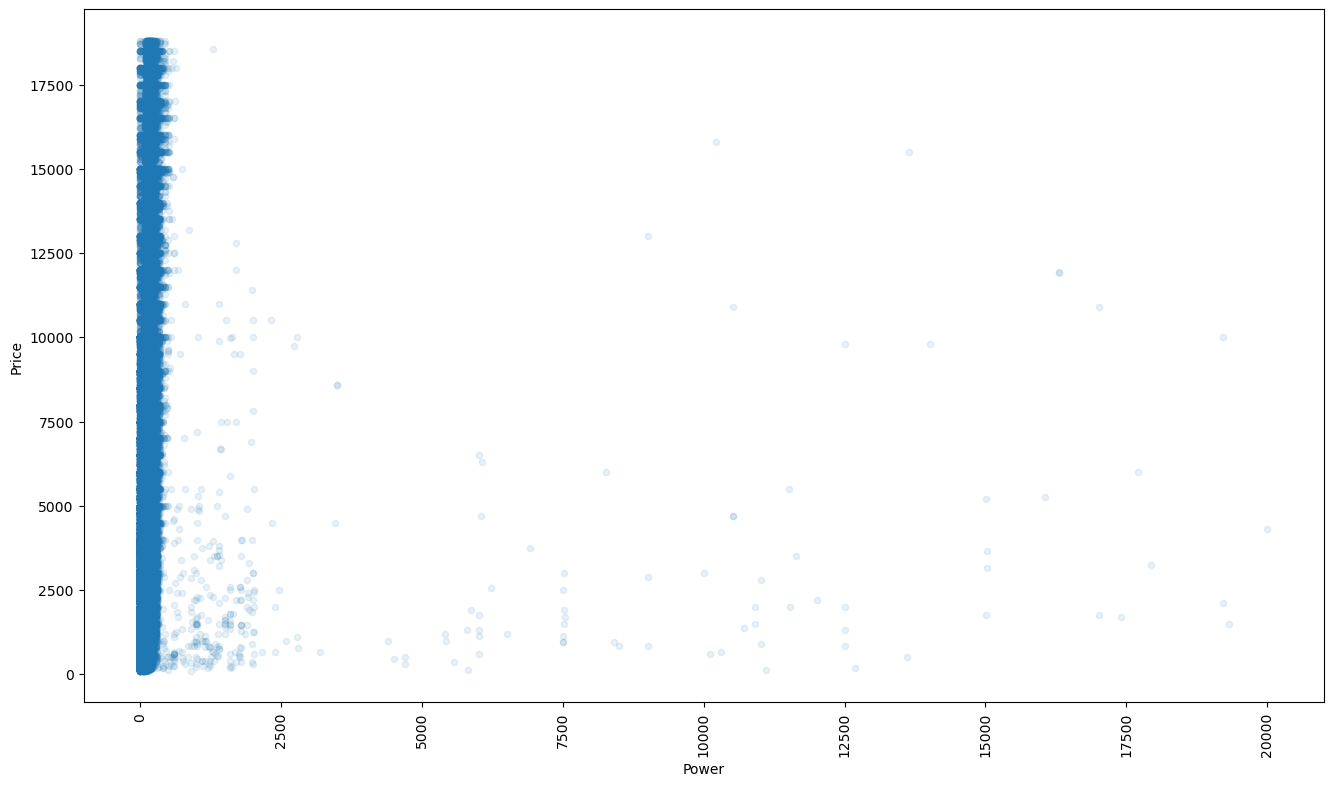

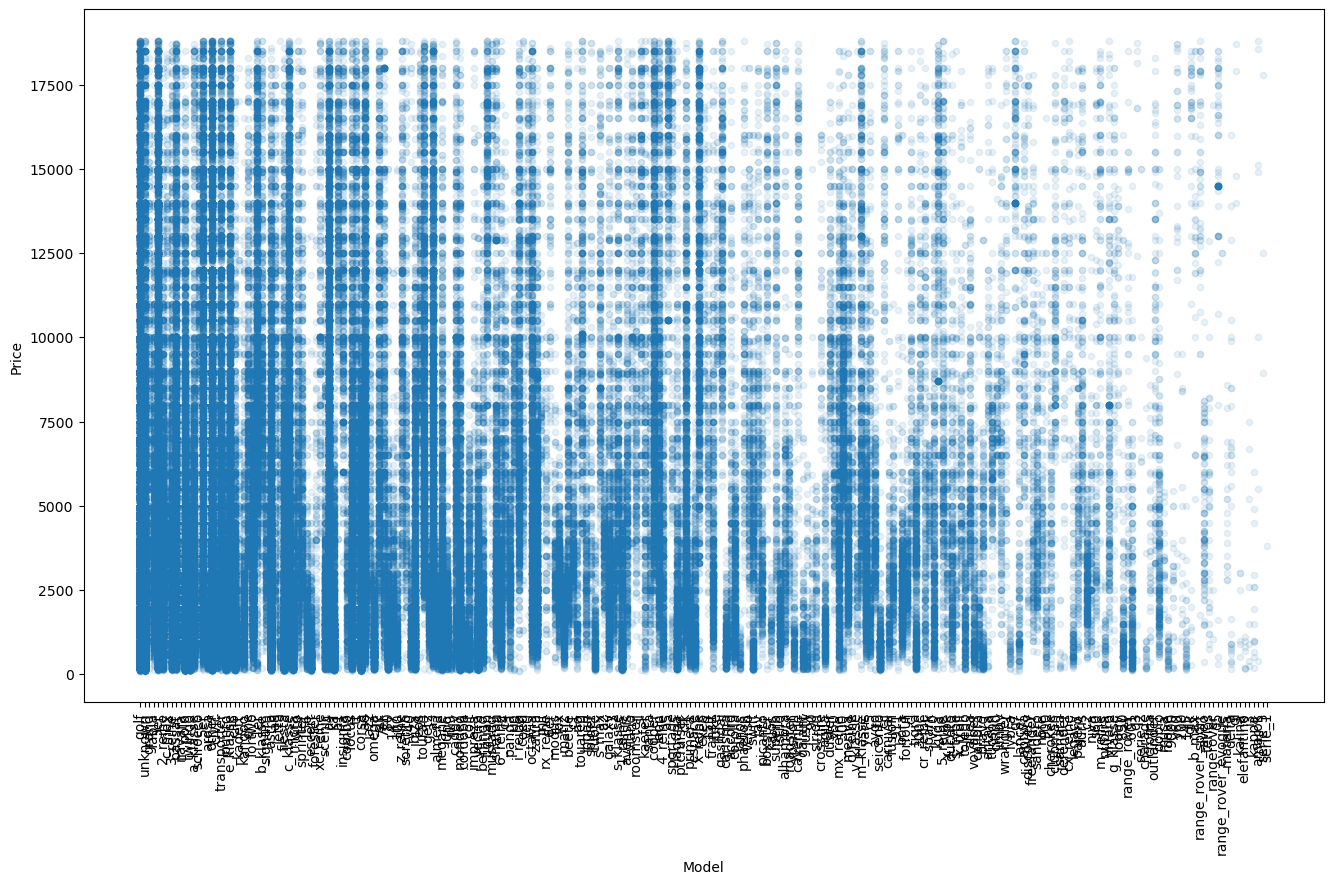

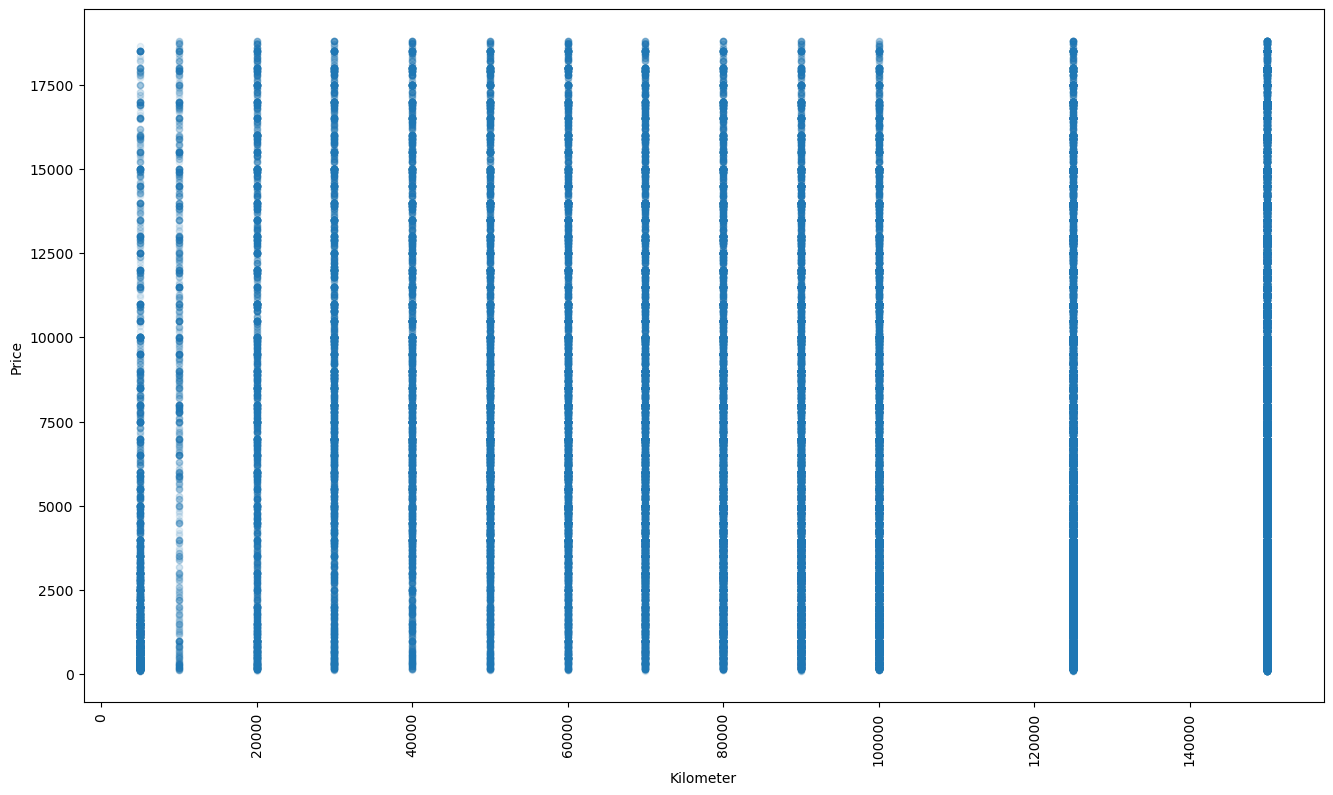

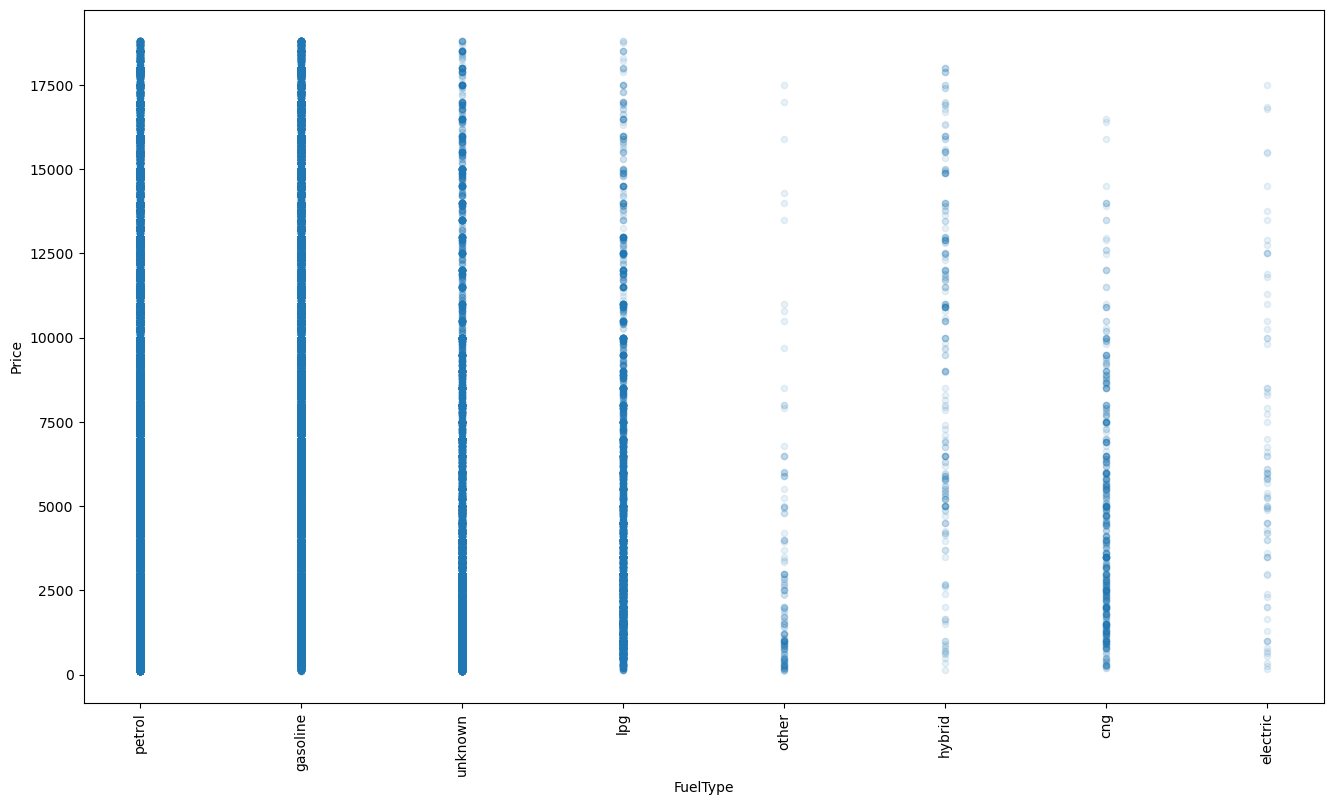

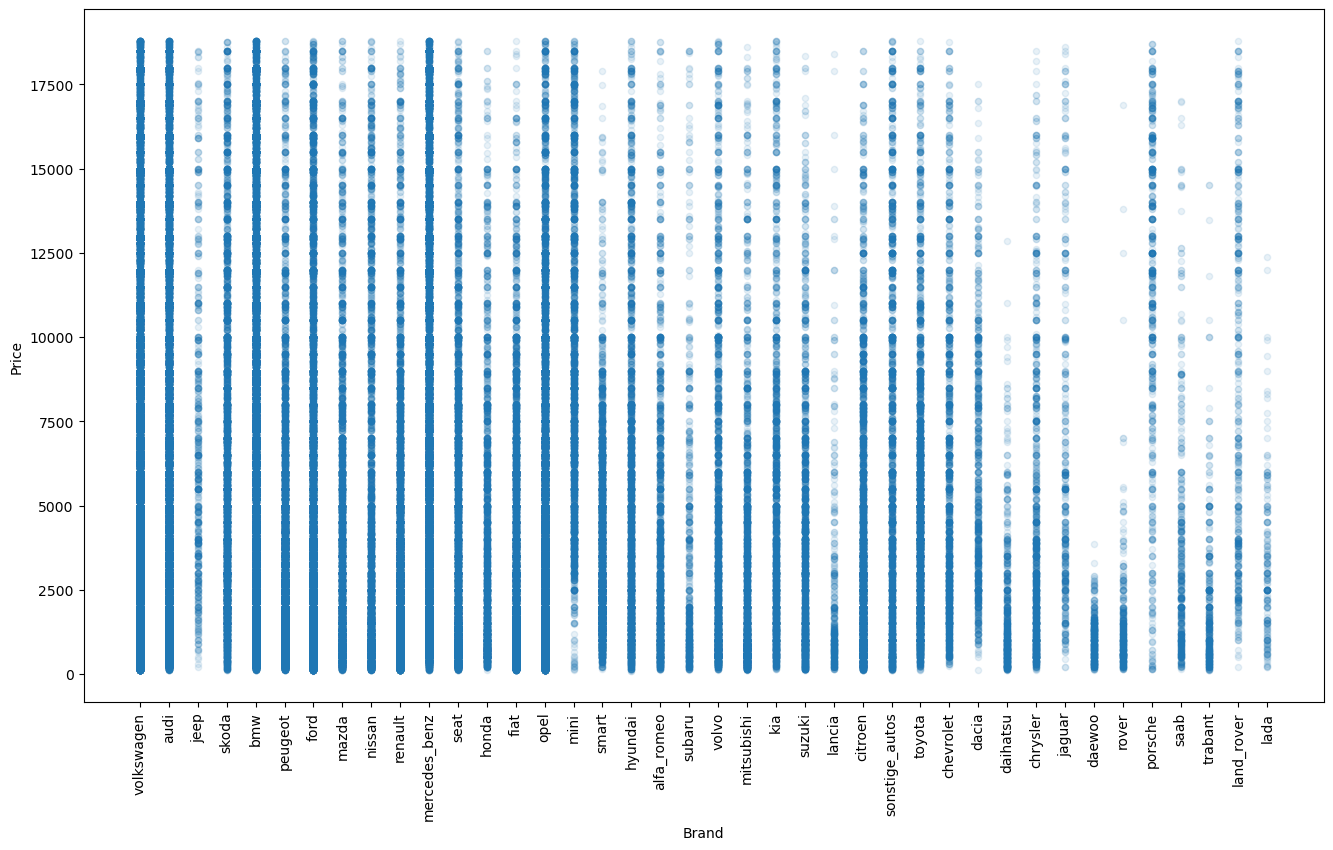

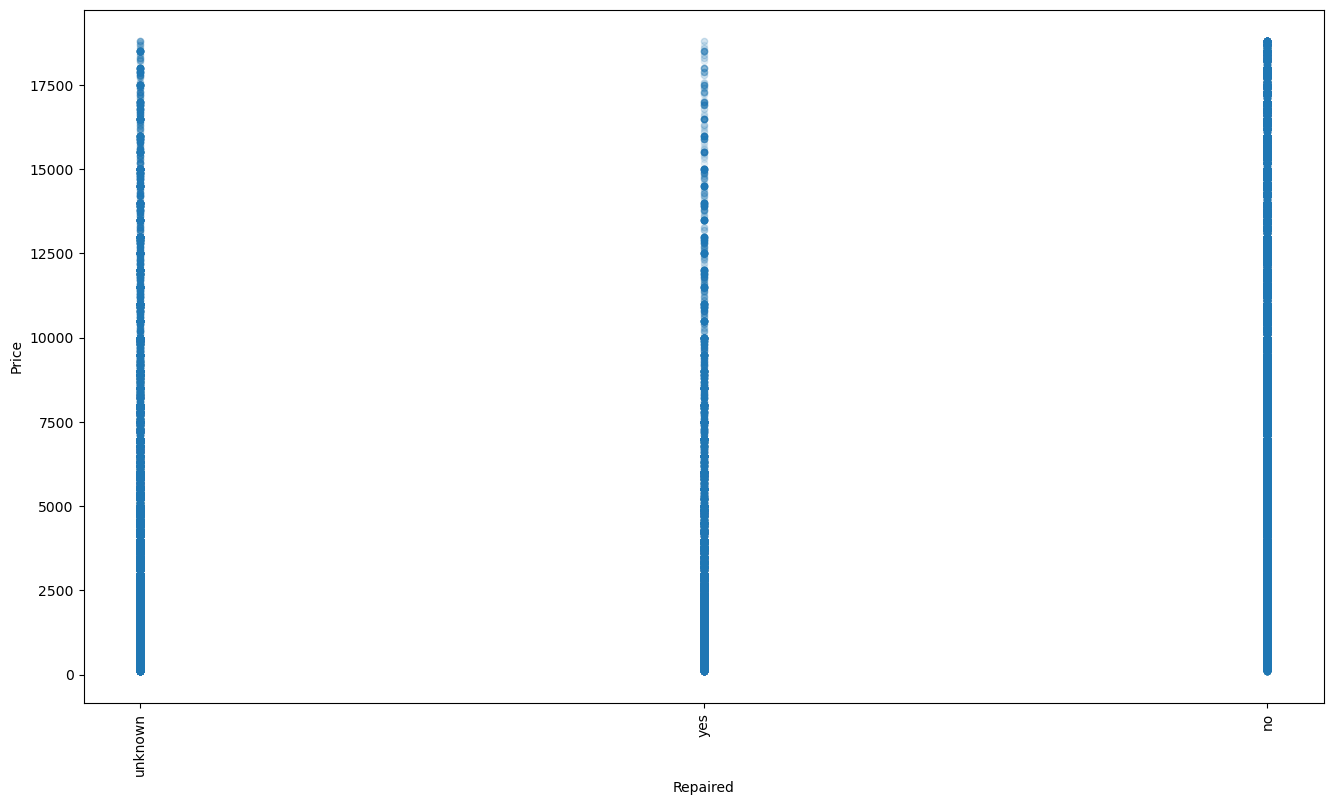

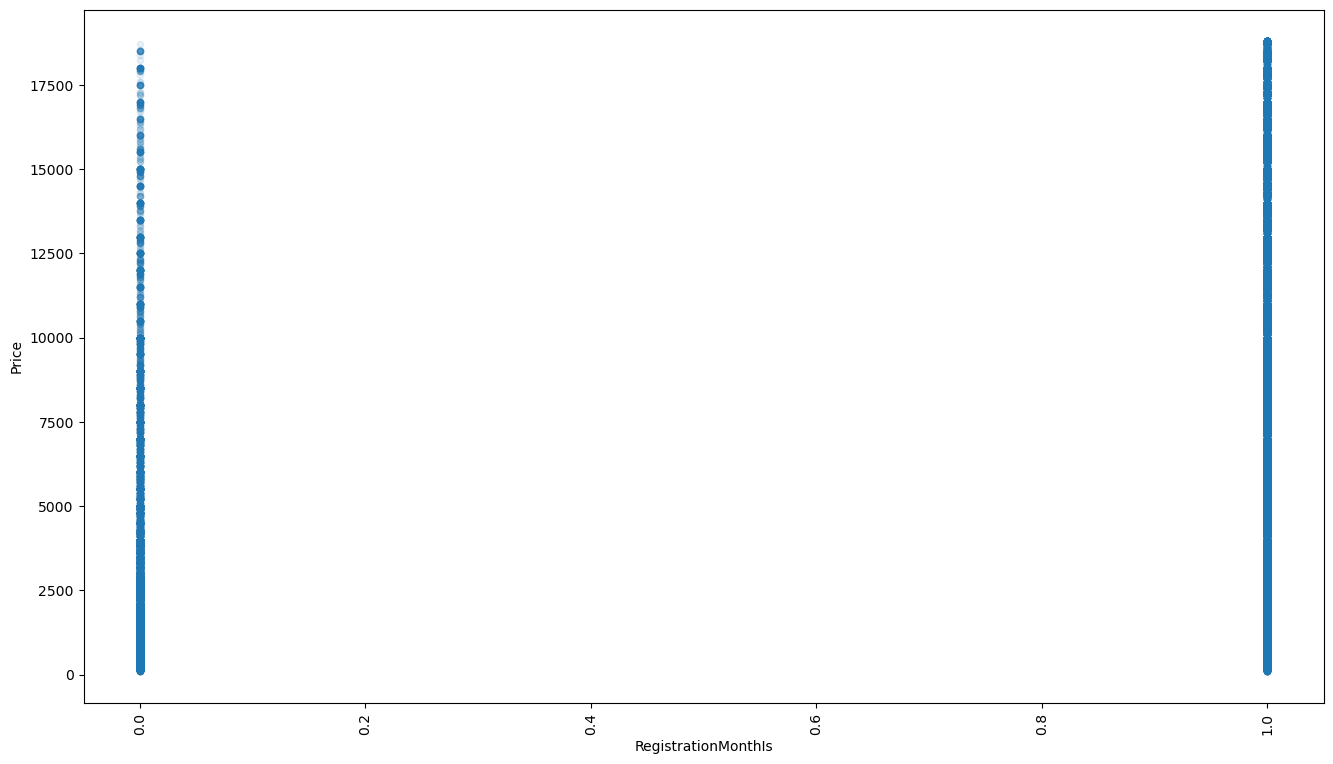

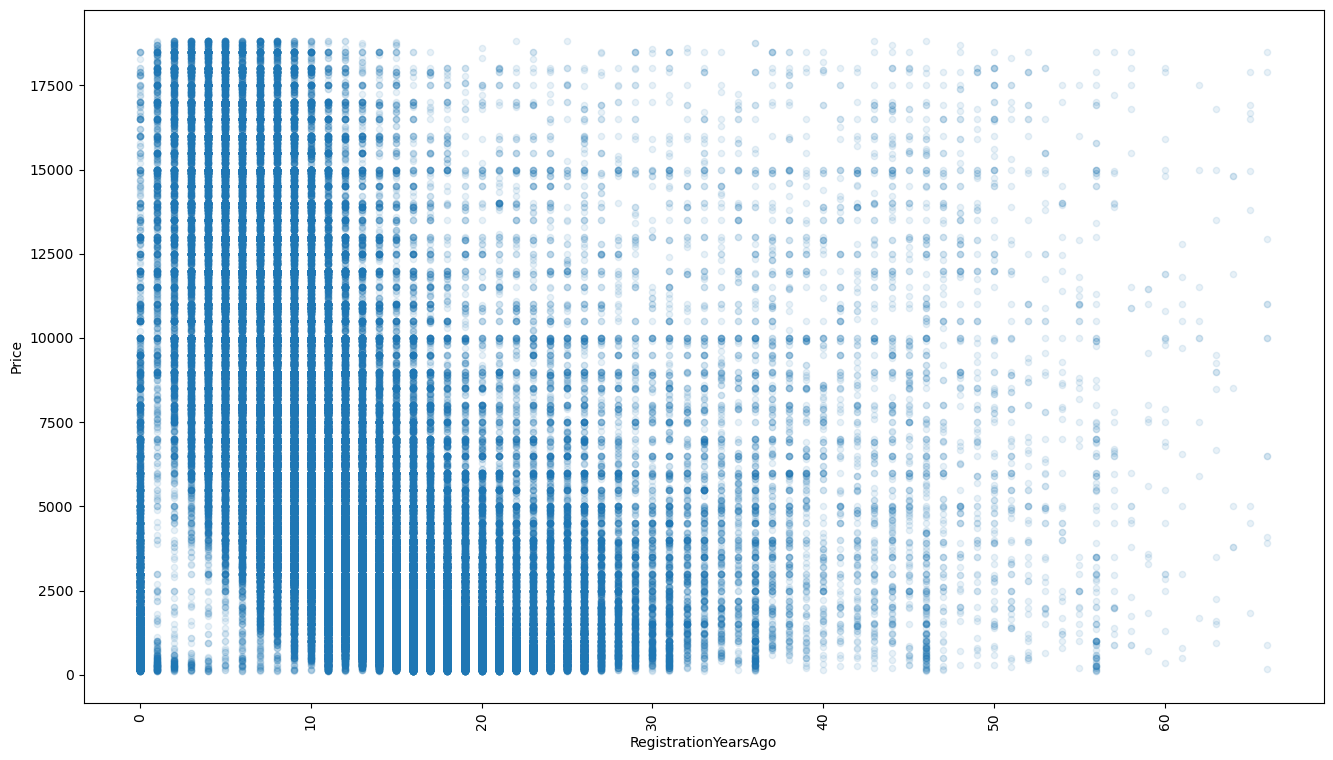

In [50]:
for i in df.drop('Price', axis=1).columns:
    df.plot(kind='scatter', x=i, y='Price', alpha=0.1, figsize=(16, 9), rot=90)
    plt.show()

### Analyzing the data in the VehicleType column

In [51]:
df['VehicleType'].value_counts()

sedan          88017
small          76922
wagon          62782
bus            27921
convertible    19312
unknown        18483
coupe          15092
suv            11278
other           3011
Name: VehicleType, dtype: int64

There are not many unique values. Quite a lot of unknown data. But let's leave it as it is for now

### Analyzing the data in the Brand column

Let's check for hidden duplicates and omissions

In [52]:
df['Brand'].value_counts().sort_index()

alfa_romeo         2118
audi              26891
bmw               33905
chevrolet          1623
chrysler           1300
citroen            4724
dacia               862
daewoo              493
daihatsu            727
fiat               8736
ford              22965
honda              2564
hyundai            3357
jaguar              461
jeep                609
kia                2264
lada                206
lancia              426
land_rover          512
mazda              5184
mercedes_benz     29548
mini               2969
mitsubishi         2769
nissan             4532
opel              36048
peugeot           10303
porsche             635
renault           16162
rover               427
saab                495
seat               6248
skoda              5241
smart              4938
sonstige_autos     2438
subaru              695
suzuki             2171
toyota             4350
trabant             459
volkswagen        69461
volvo              3002
Name: Brand, dtype: int64

I assumed that rover and land_rover are the same brand, but judging by the Wikipedia data, they are different companies. We leave the data in this form, we do not change anything

### Analyzing the data in the Kilometer column

According to the scatter plot, it was clear that the data has some discreteness in mileage. Let's check this using grouping

In [53]:
df['Kilometer'].value_counts().sort_index()

5000        4282
10000        963
20000       3436
30000       3974
40000       4515
50000       5712
60000       6947
70000       8003
80000       9331
90000      10765
100000     13649
125000     33841
150000    217400
Name: Kilometer, dtype: int64

Okay, we see that all the data is completely divided into a thousand. Let's try to display the boxplots in order to compare the effect of mileage on the price

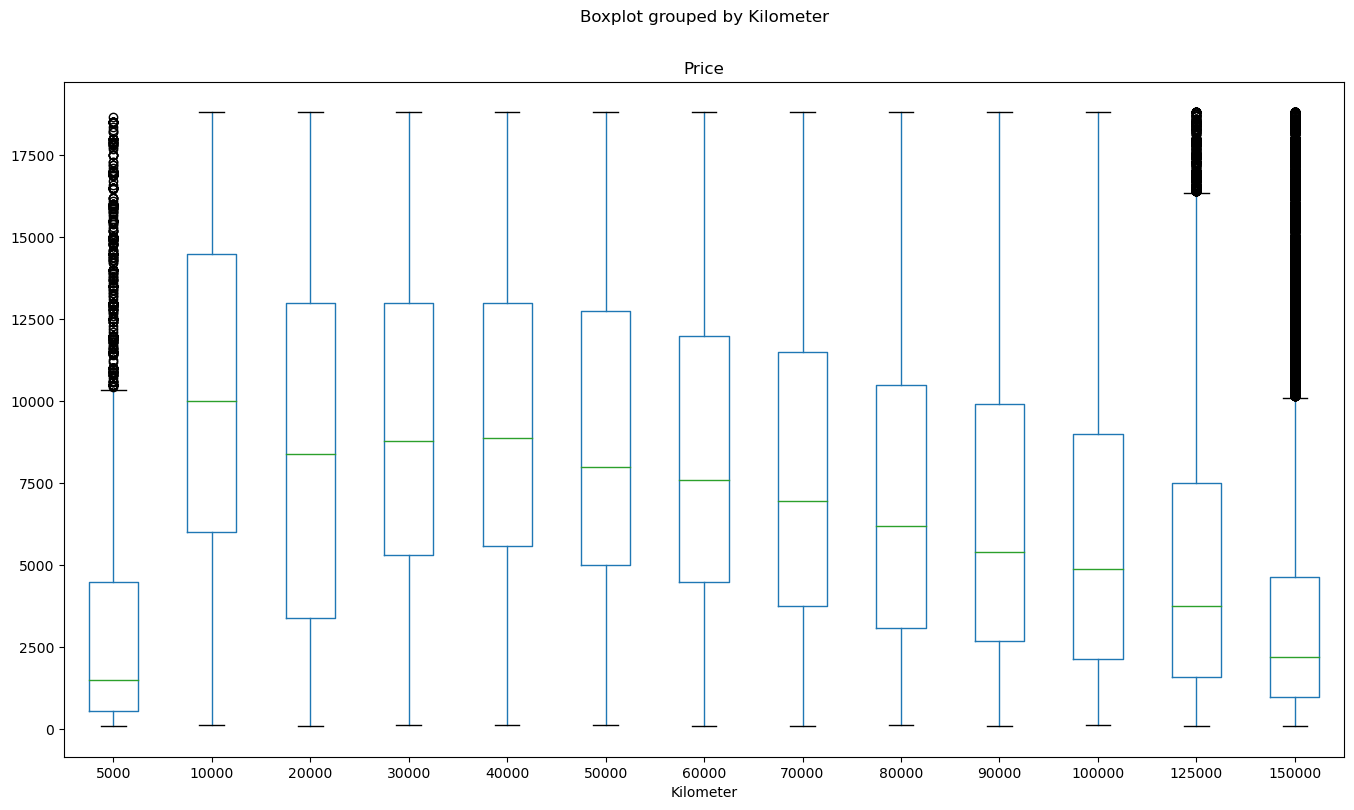

In [54]:
df.boxplot(column='Price', by='Kilometer', rot=0, grid=False, figsize=(16, 9))
plt.show()

According to this graph, the decrease in cost with an increase in mileage is clearly visible. Only those cases where the mileage is 5000 km are knocked out. I assume that when filling out the questionnaire, the owners were asked to fill in mileage data in the format "from _ to _ thousand km". It is likely that the minimum value could have been set from 0 to 5000 km, which was set by default. If the owner did not change the values in this field, the value from 0 to 5000 km was automatically set. For now, we leave the data in this column in this form.

### Analyzing data in the Power column

In [55]:
df['Power'].value_counts()

0       31048
75      21919
60      14556
150     13531
101     12369
        ...  
5815        1
6018        1
612         1
1596        1
1241        1
Name: Power, Length: 673, dtype: int64

We see a large number of zero values

In [56]:
df[(df['Power'] == 0) | (df['Power'] > 1000)]

Price VehicleType  Gearbox  Power      Model  Kilometer  FuelType  \
0         480     unknown   manual      0       golf     150000    petrol   
32        245       sedan  unknown      0       golf     150000    petrol   
37       1500     unknown  unknown      0     kangoo     150000  gasoline   
54       4700       wagon   manual      0     signum     150000   unknown   
55        550       wagon   manual      0      astra     150000  gasoline   
...       ...         ...      ...    ...        ...        ...       ...   
354336   3299     unknown     auto      0  outlander     150000    petrol   
354338    180     unknown  unknown      0    unknown     125000    petrol   
354346   2600     unknown     auto      0   c_klasse     150000   unknown   
354363   1150         bus   manual      0     zafira     150000    petrol   
354365   2200     unknown  unknown      0    unknown      20000   unknown   

                 Brand Repaired  RegistrationMonthIs  RegistrationYearsAgo  
0           volkswagen  unknown                    0                    23  
32          volkswagen       no                    1                    22  
37             renault       no                    1                     0  
54                opel       no                    0                    11  
55                opel      yes                    1                    17  
...                ...      ...                  ...                   ...  
354336      mitsubishi  unknown                    1                    11  
354338            opel  unknown                    1                    21  
354346   mercedes_benz  unknown                    1                    11  
354363            opel       no                    1                    16  
354365  sonstige_autos  unknown                    1                    11  

[31306 rows x 11 columns]

In [57]:
df[(df['Power'] > 1500)]

Price VehicleType Gearbox  Power     Model  Kilometer  FuelType  \
7661     1499       small  manual   7515      lupo     150000    petrol   
9664     2599     unknown  manual   1779    zafira     150000    petrol   
9875      550       wagon  manual   1753     focus     150000  gasoline   
19092    9750       wagon    auto   2729       5er     150000  gasoline   
20050    2200       sedan    auto   1704  e_klasse     150000   unknown   
...       ...         ...     ...    ...       ...        ...       ...   
348006    355       sedan  manual   1799    vectra     150000    petrol   
348137    850       sedan    auto   9012      golf     150000    petrol   
348237   3000       coupe  manual   2007     corsa     150000  gasoline   
348668   1000       wagon  manual   2598        a6     150000   unknown   
348883   7500       sedan  manual   1548    scenic      90000    petrol   

                Brand Repaired  RegistrationMonthIs  RegistrationYearsAgo  
7661       volkswagen  unknown                    1                    17  
9664             opel       no                    0                     0  
9875             ford      yes                    1                    13  
19092             bmw       no                    1                    11  
20050   mercedes_benz      yes                    1                    14  
...               ...      ...                  ...                   ...  
348006           opel  unknown                    1                    18  
348137     volkswagen  unknown                    0                    23  
348237           opel      yes                    1                     9  
348668           audi  unknown                    1                    20  
348883        renault  unknown                    1                     5  

[170 rows x 11 columns]

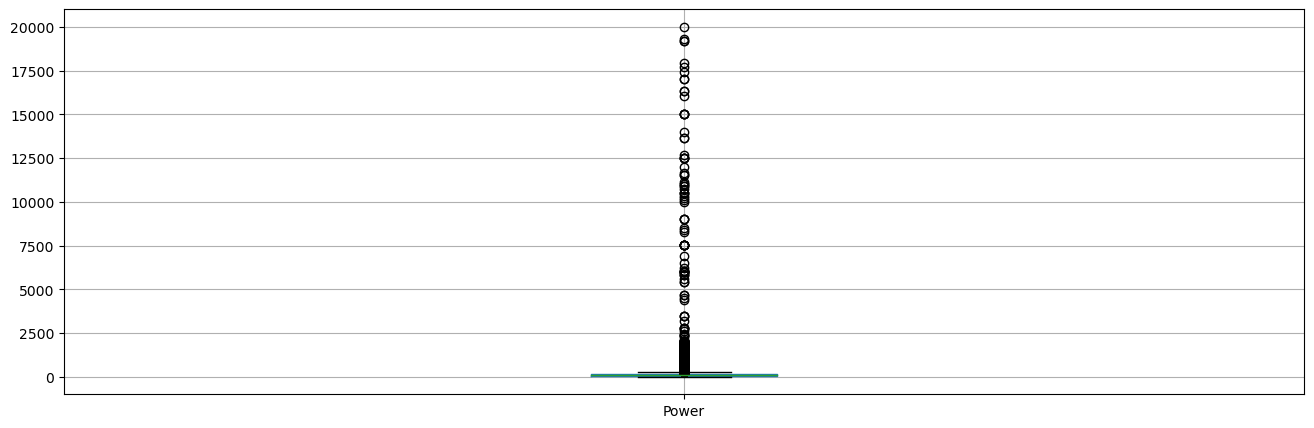

In [58]:
df.boxplot(column='Power', rot=0, grid=True, figsize=(16, 5))
plt.show()

Let's try to fill in the zero values and change the outlier values to the median values according to the model. First, let's define what is the upper limit of emissions. To do this, we use the average plus 3 standard deviations

In [59]:
up_border_power = df['Power'].mean() + 3 * df['Power'].std()
up_border_power

669.8519750423013

Okay I will delete the values that are zero and that are above 1500 hp. I took this information from the link below. Although it seems to me that it is not particularly useful in our case. It is unlikely that this is in the price range that is in the data for this project (up to 20,000 euros)

https://quto.ru/journal/articles/kak-menyalas-srednyaya-moshnost-avtomobilei-za-vremya-sushestvovaniya-industrii.htm

Let's check how the data has changed

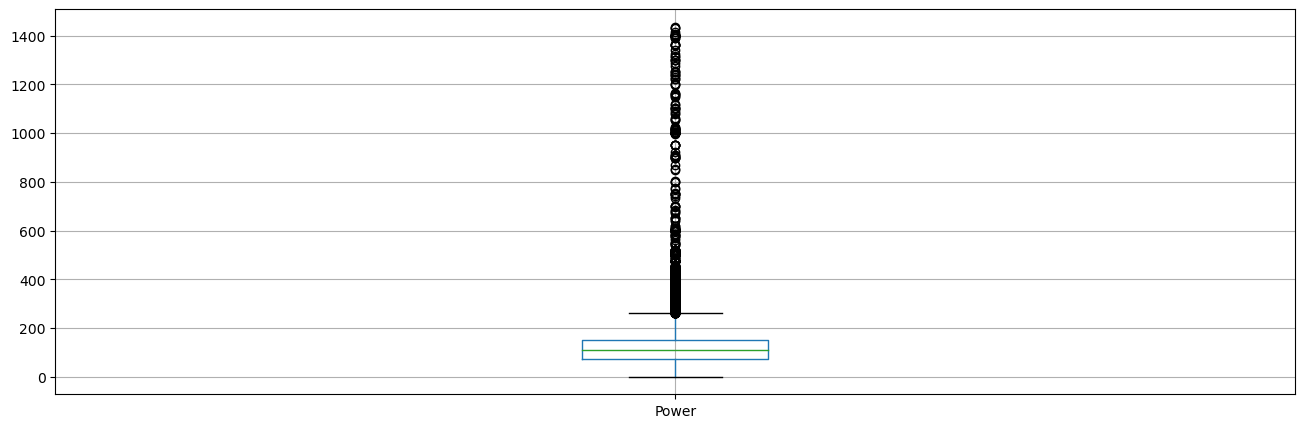

In [60]:
df[(df['Power'] > 0) & (df['Power'] < 1500)].boxplot(column='Power', rot=0, grid=True, figsize=(16, 5))
plt.show()

We leave the data in this form

Let's draw a graph of the dependence of the price of a car on power

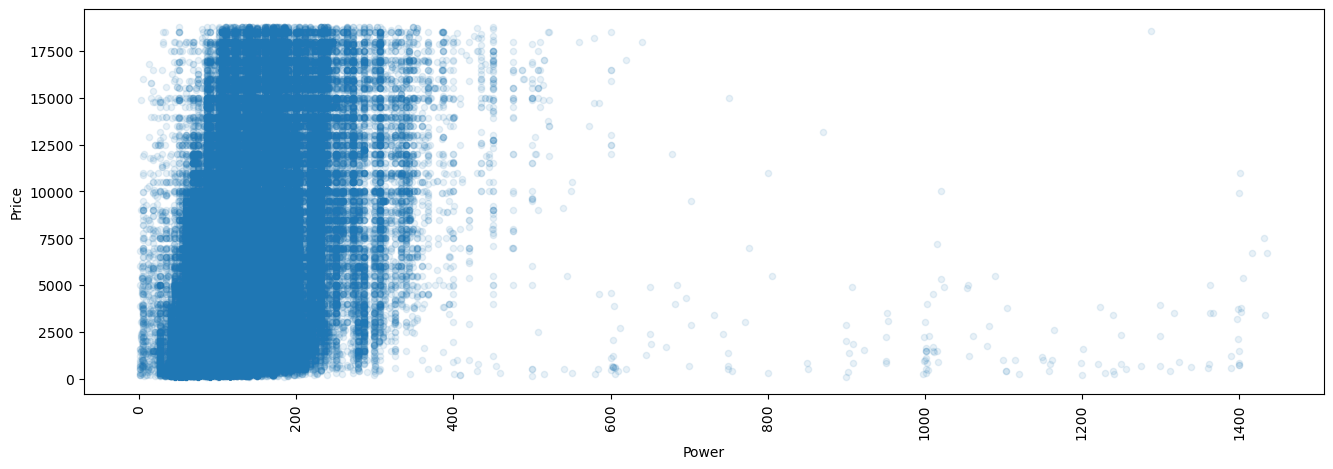

In [61]:
df[(df['Power'] > 0) & (df['Power'] < 1500)].plot(kind='scatter', x='Power', y='Price', alpha=0.1, figsize=(16, 5), rot=90)
plt.show()

Although according to the graph above, we see that the cost of cars with a number of hp above 600 remains relatively low, which is not very logical. Let's leave here, probably, the data in which the Power is greater than zero. And we define the upper bound as the average + 3 standard deviations

In [62]:
df = df[(df['Power'] > 0) & (df['Power'] < up_border_power)]

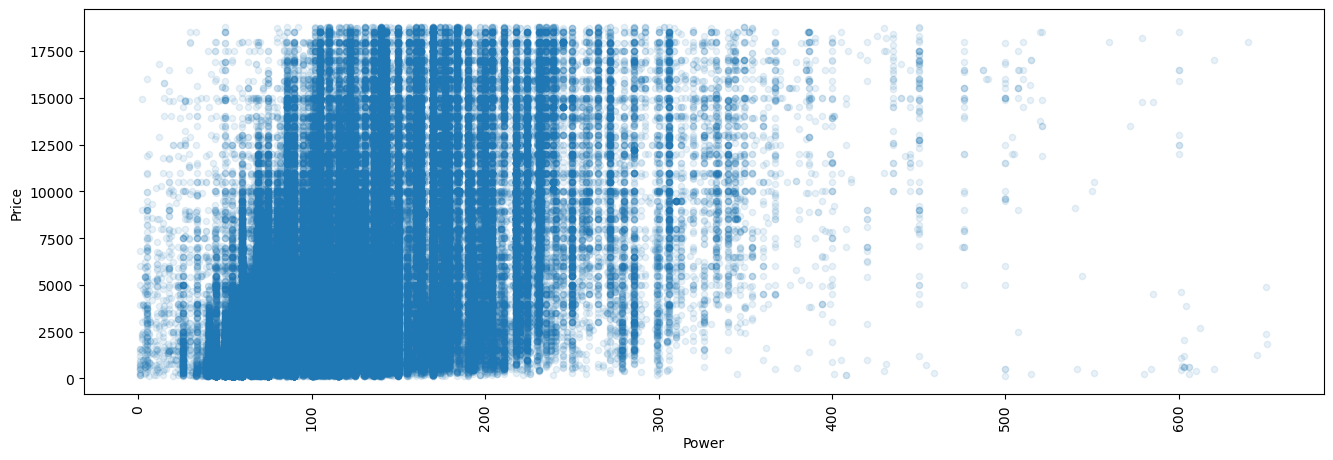

In [63]:
df.plot(kind='scatter', x='Power', y='Price', alpha=0.1, figsize=(16, 5), rot=90)
plt.show()

### Analyzing the data in the Model column

Here are the 10 most common models

In [64]:
df['Model'].value_counts().head(10)

golf        24359
other       20018
3er         17125
unknown     10892
polo        10555
corsa        9964
astra        9004
passat       8700
a4           8660
c_klasse     7155
Name: Model, dtype: int64

Let's print the number of unique values in this column

In [65]:
len(df['Model'].unique())

250

### Analysis of data on the Repaired column

Previously, we filled in the missing values in this column with unknown values. Let's see how the price of a car is distributed depending on each category

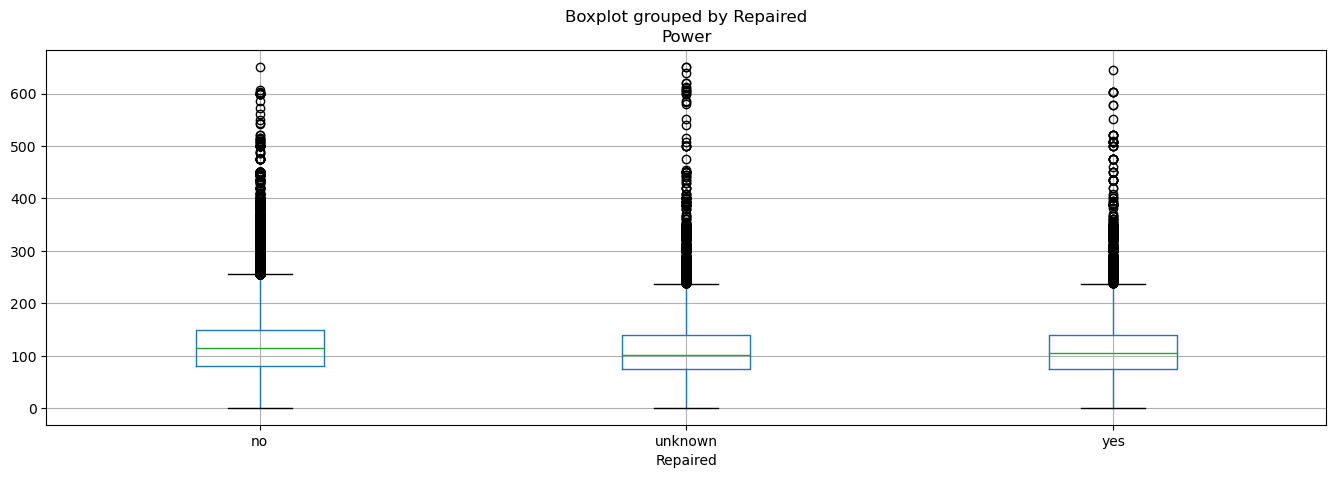

In [66]:
df.boxplot(column='Power', by='Repaired',rot=0, grid=True, figsize=(16, 5))
plt.show()

The boxplot shows that the distribution of the price of a car with the value Repaired = unknown is similar to the distribution where Repaired = yes. It can be assumed that if the owner does not indicate whether the car was under repair, then it is more likely that it was. Let's change the unknown values to yes values

In [67]:
df.loc[df['Repaired'] == 'unknown', 'Repaired'] = 'yes'

Checking it out

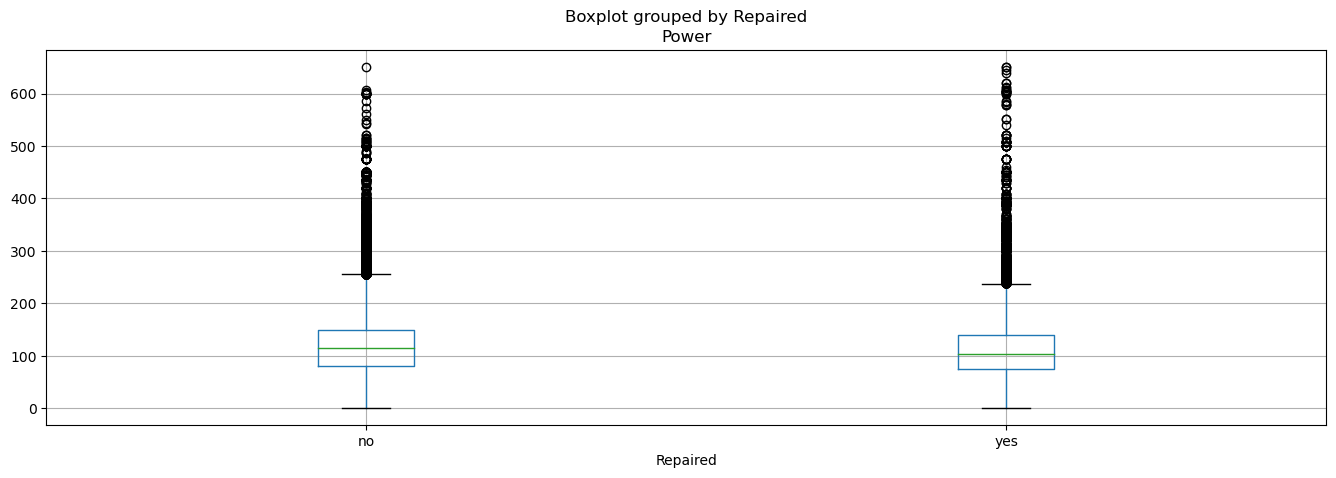

In [68]:
df.boxplot(column='Power', by='Repaired',rot=0, grid=True, figsize=(16, 5))
plt.show()

### Analyzing data in the FuelType column

In [69]:
df['FuelType'].value_counts()

petrol      184899
gasoline     85922
unknown      15158
lpg           4656
cng            480
hybrid         193
other           90
electric        72
Name: FuelType, dtype: int64

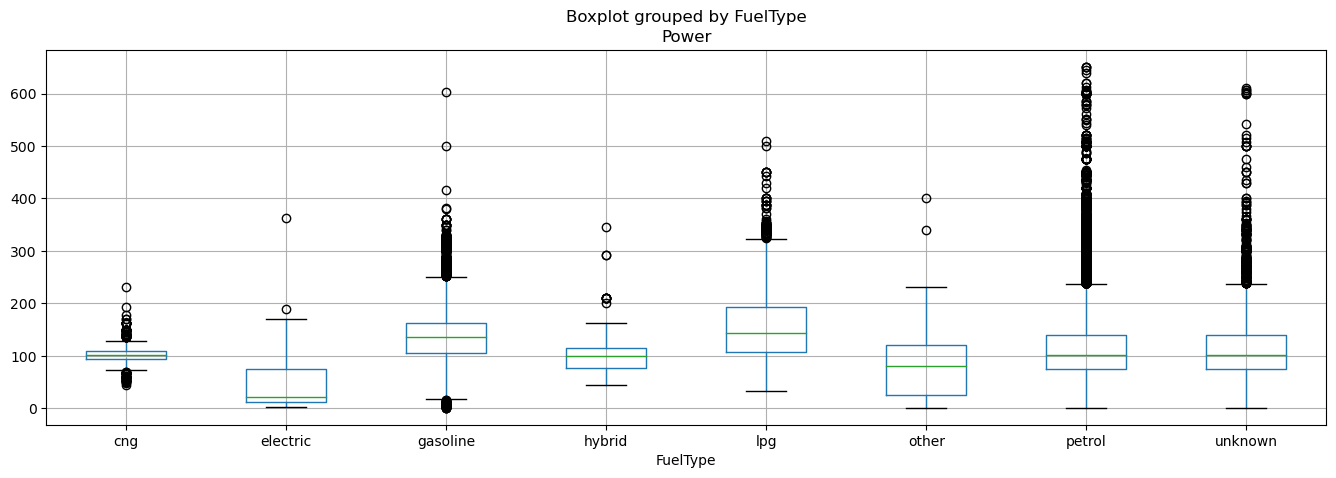

In [70]:
df.boxplot(column='Power', by='FuelType',rot=0, grid=True, figsize=(16, 5))
plt.show()

Indeed, gasoline and petrol are different names for gasoline, let's combine them into one class

In [71]:
df.loc[df['FuelType'] == 'gasoline', 'FuelType'] = 'petrol'

In [72]:
df['FuelType'].value_counts()

petrol      270821
unknown      15158
lpg           4656
cng            480
hybrid         193
other           90
electric        72
Name: FuelType, dtype: int64

### Let's look at what data is left in the end

Let's output general information about the dataframe

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291470 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Price                 291470 non-null  int64 
 1   VehicleType           291470 non-null  object
 2   Gearbox               291470 non-null  object
 3   Power                 291470 non-null  int64 
 4   Model                 291470 non-null  object
 5   Kilometer             291470 non-null  int64 
 6   FuelType              291470 non-null  object
 7   Brand                 291470 non-null  object
 8   Repaired              291470 non-null  object
 9   RegistrationMonthIs   291470 non-null  int64 
 10  RegistrationYearsAgo  291470 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 26.7+ MB


In [74]:
phik_overview = df.dropna().phik_matrix()
phik_overview.round(2)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 8))
plt.tight_layout()

interval columns not set, guessing: ['Price', 'Power', 'Kilometer', 'RegistrationMonthIs', 'RegistrationYearsAgo']


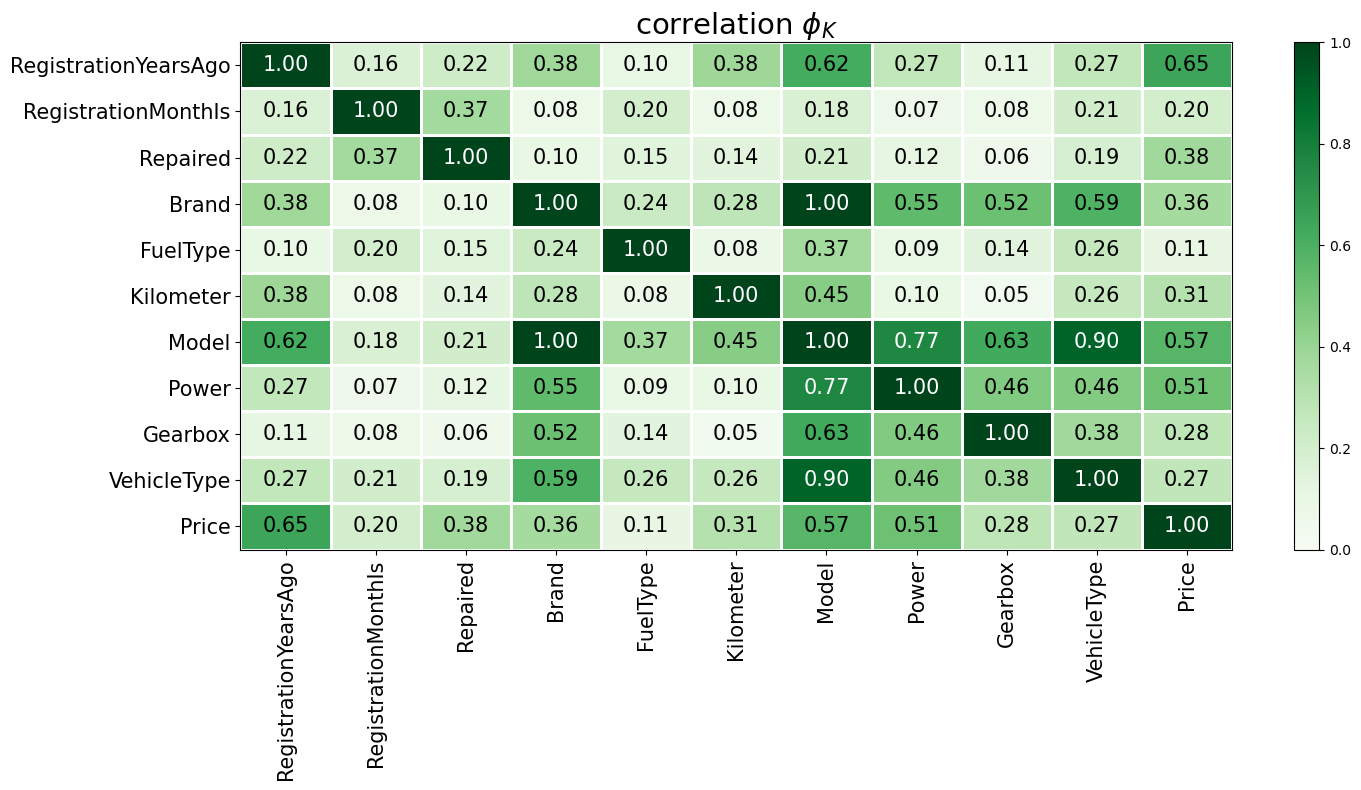

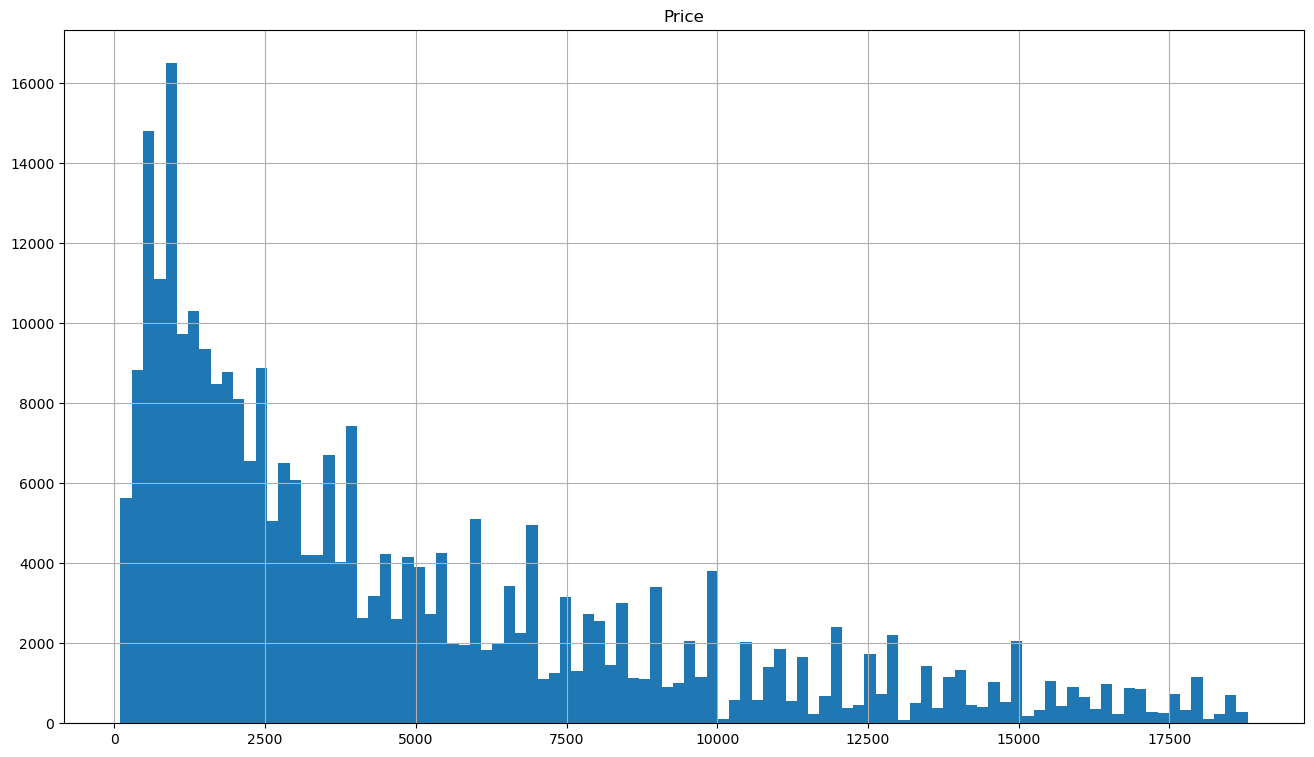

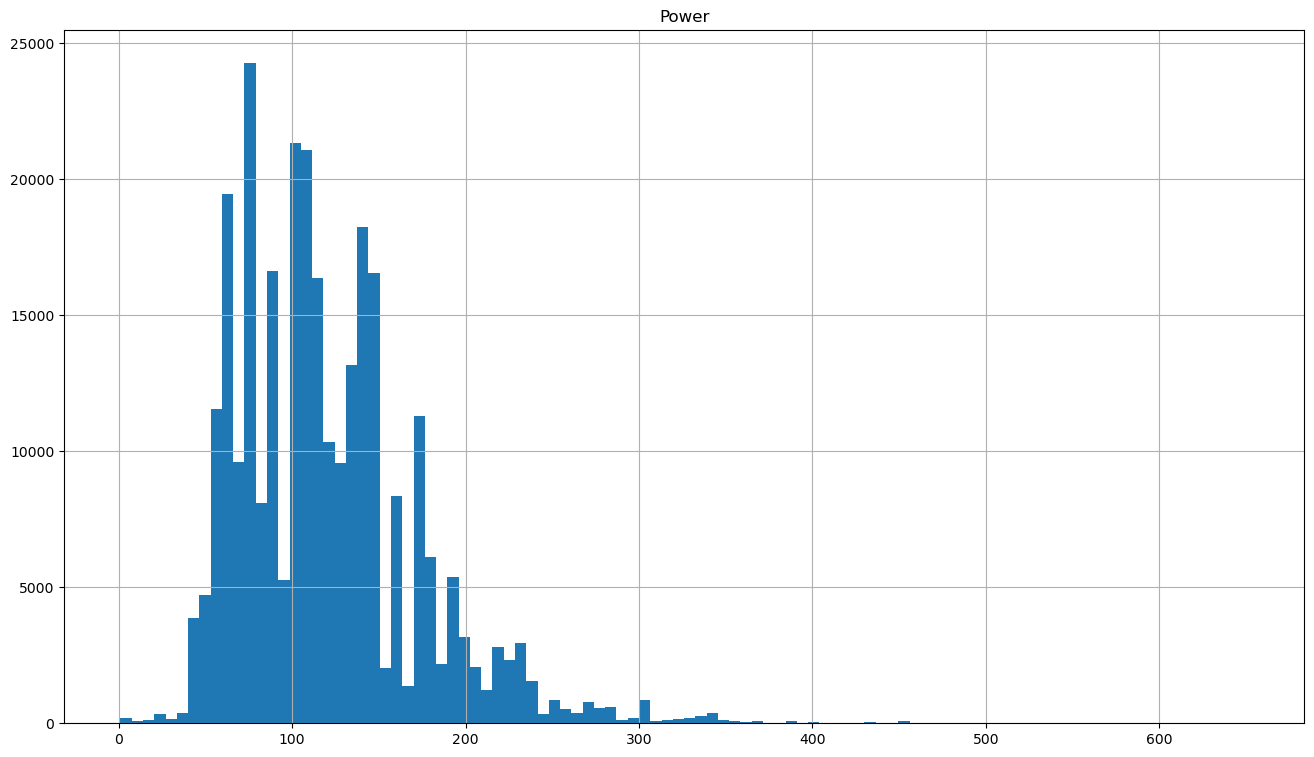

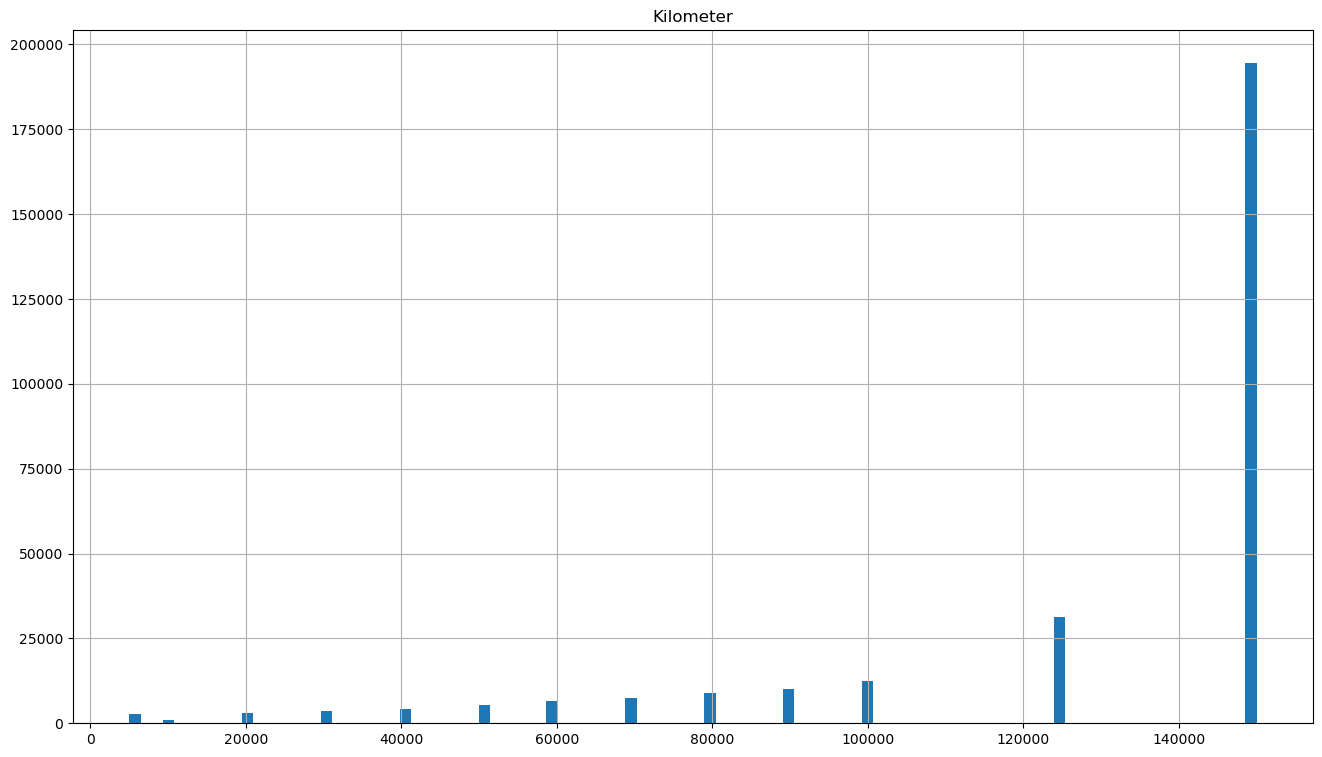

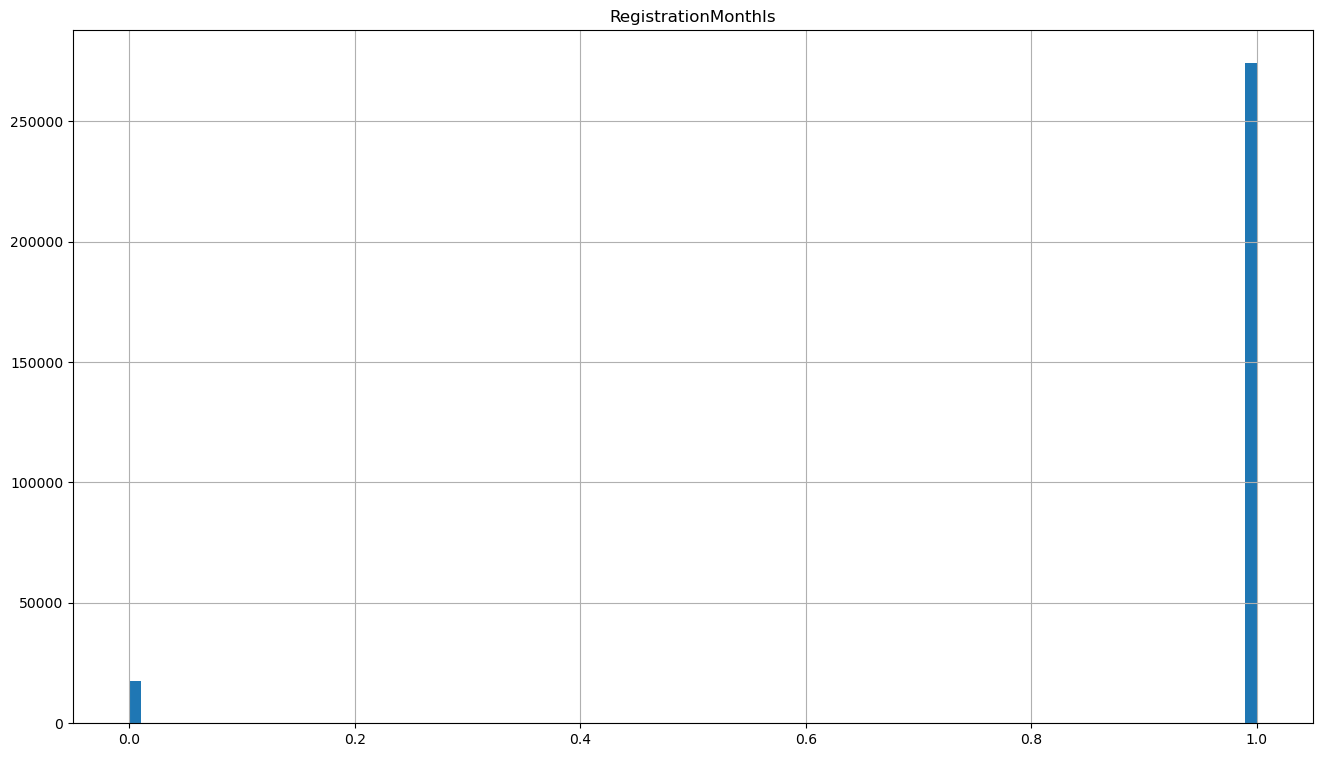

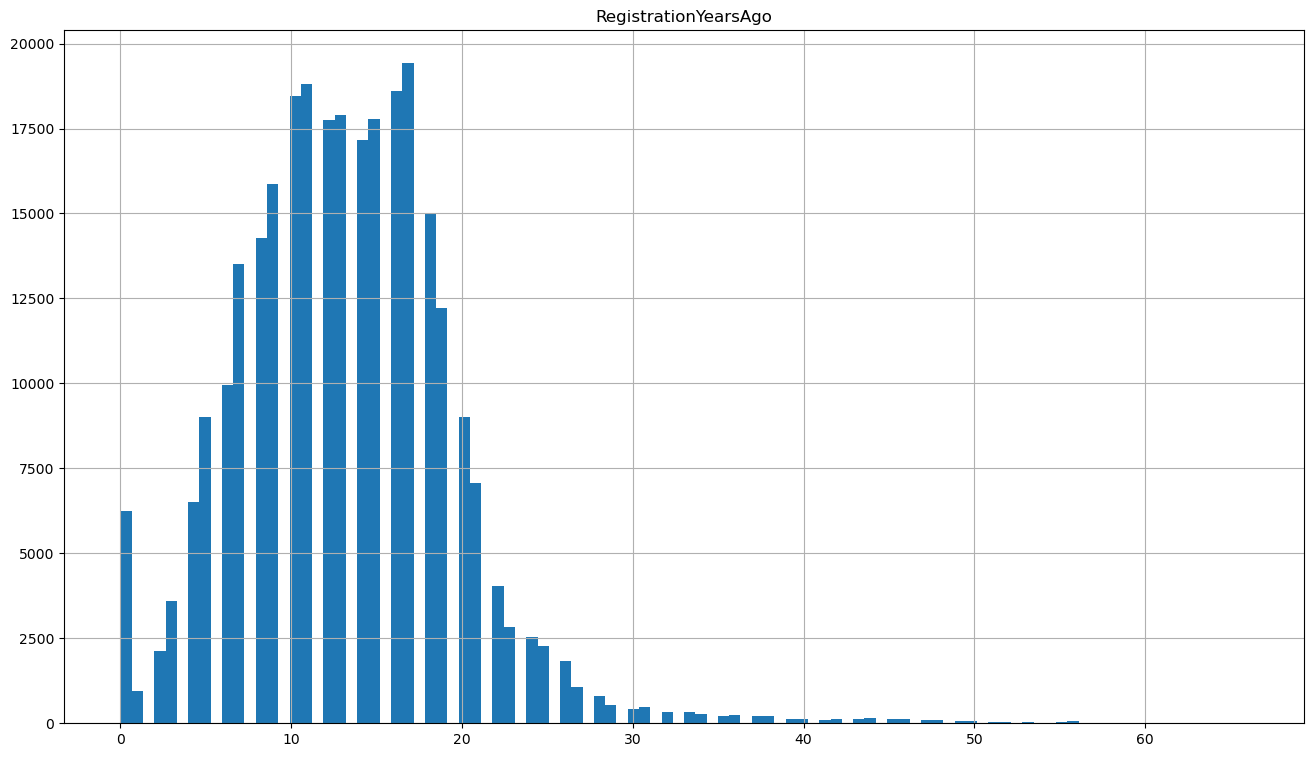

In [75]:
list_for_bar_plot = []
for i in df.columns:
    try:
        df.hist(column=i, figsize=(16,9), bins=100)
        plt.show()
    except:
        list_for_bar_plot.append(i)

### Let's define the target and features. Let's divide the sample into a training and a test one

In [76]:
X = df.drop('Price', axis=1)
y = df['Price']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2007)

### Defining lists with categorical and numeric features

In [78]:
X.columns

Index(['VehicleType', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType',
       'Brand', 'Repaired', 'RegistrationMonthIs', 'RegistrationYearsAgo'],
      dtype='object')

In [79]:
num = ['Power', 'RegistrationMonthIs', 'RegistrationYearsAgo']
cat = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired', 'Kilometer', 'Model']

### Converting data using pipeline

We transform numerical features using standardization

In [80]:
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

We transform categorical features using OHE

In [81]:
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

Passing OHE and standard scaler to column transformer

In [82]:
preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_transformer, num),
        ('cat', categorical_transformer, cat)
    ])

## Model Training

Deleting initial dataframe

In [83]:
del df 

### Creating a decision tree model

We pass the preprocessor and the decision tree model to the final pipeline

In [84]:
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=2007))
])

Setting parameters for grid search

In [85]:
param_grid_dt = {
    'model__max_depth': range(1, 20),
#    'model__min_samples_split': [2, 5, 10],
#    'model__min_samples_leaf': [1, 2, 4]
}

We pass the pipeline and parameters to gridsearch to find the best model

In [86]:
grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='neg_mean_squared_error')

We train the model on a training sample. Let's output the code execution time

In [87]:
%%time
grid_search_dt.fit(X_train, y_train)

C:\Users\gogad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros

C:\Users\gogad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros

C:\Users\gogad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros

C:\Users\gogad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros

C:\Users\gogad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [6] during transform. These

Wall time: 4min 37s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Power',
                                                                          'RegistrationMonthIs',
                                                                          'RegistrationYearsAgo']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                        

Let's output the parameters of the best model

In [88]:
grid_search_dt.best_params_

{'model__max_depth': 18}

In [89]:
np.sqrt(-grid_search_dt.best_score_)

1774.3113269642706

Let's check the RMSE on a training sample

Let's train the decision tree on the entire training sample with the resulting hyperparameters in GridSearch

In [90]:
final_model_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=2007, max_depth=18))
])

In [91]:
%%time
final_model_dt = final_model_dt.fit(X_train, y_train)

Wall time: 9.24 s


### Let's create a LightGBM model

We pass the preprocessor and LGBMRegressor to the final pipeline

In [92]:
pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMRegressor(random_state=2007, force_col_wise=True))
])

Setting parameters for grid search

In [93]:
param_grid_gb = {
    'model__learning_rate': [0.05],
    'model__n_estimators': range(10, 150, 10),
#    'model__num_leaves': [20, 31, 40]
}

We pass the pipeline and parameters to gridsearch to find the best model

In [94]:
grid_search_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=5, scoring='neg_mean_squared_error')

We train the model on a training sample. Let's output the code execution time

In [95]:
%%time
grid_search_gb.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 186540, number of used features: 301
[LightGBM] [Info] Start training from score 4718.151453
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 299
[LightGBM] [Info] Start training from score 4706.469516
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 301
[LightGBM] [Info] Start training from score 4715.695429
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 300
[LightGBM] [Info] Start training from score 4719.628677
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 302
[LightGBM] [Info] Start training from score 4707.250738


C:\Users\gogad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros



[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 186540, number of used features: 301
[LightGBM] [Info] Start training from score 4718.151453
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 299
[LightGBM] [Info] Start training from score 4706.469516
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 301
[LightGBM] [Info] Start training from score 4715.695429
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 300
[LightGBM] [Info] Start training from score 4719.628677
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 302
[LightGBM] [Info] Start training from score 4707.250738


C:\Users\gogad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros



[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 186540, number of used features: 301
[LightGBM] [Info] Start training from score 4718.151453
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 299
[LightGBM] [Info] Start training from score 4706.469516
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 301
[LightGBM] [Info] Start training from score 4715.695429
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 300
[LightGBM] [Info] Start training from score 4719.628677
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 302
[LightGBM] [Info] Start training from score 4707.250738


C:\Users\gogad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros



[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 186540, number of used features: 301
[LightGBM] [Info] Start training from score 4718.151453
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 299
[LightGBM] [Info] Start training from score 4706.469516
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 301
[LightGBM] [Info] Start training from score 4715.695429
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 300
[LightGBM] [Info] Start training from score 4719.628677
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 302
[LightGBM] [Info] Start training from score 4707.250738


C:\Users\gogad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros



[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 186540, number of used features: 301
[LightGBM] [Info] Start training from score 4718.151453
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 299
[LightGBM] [Info] Start training from score 4706.469516
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 301
[LightGBM] [Info] Start training from score 4715.695429
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 300
[LightGBM] [Info] Start training from score 4719.628677
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 302
[LightGBM] [Info] Start training from score 4707.250738


C:\Users\gogad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros



[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 186540, number of used features: 301
[LightGBM] [Info] Start training from score 4718.151453
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 299
[LightGBM] [Info] Start training from score 4706.469516
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 301
[LightGBM] [Info] Start training from score 4715.695429
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 300
[LightGBM] [Info] Start training from score 4719.628677
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 302
[LightGBM] [Info] Start training from score 4707.250738


C:\Users\gogad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros



[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 186540, number of used features: 301
[LightGBM] [Info] Start training from score 4718.151453
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 299
[LightGBM] [Info] Start training from score 4706.469516
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 301
[LightGBM] [Info] Start training from score 4715.695429
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 300
[LightGBM] [Info] Start training from score 4719.628677
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 302
[LightGBM] [Info] Start training from score 4707.250738


C:\Users\gogad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros



[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 186540, number of used features: 301
[LightGBM] [Info] Start training from score 4718.151453
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 299
[LightGBM] [Info] Start training from score 4706.469516
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 301
[LightGBM] [Info] Start training from score 4715.695429
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 300
[LightGBM] [Info] Start training from score 4719.628677
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 302
[LightGBM] [Info] Start training from score 4707.250738


C:\Users\gogad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros



[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 186540, number of used features: 301
[LightGBM] [Info] Start training from score 4718.151453
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 299
[LightGBM] [Info] Start training from score 4706.469516
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 301
[LightGBM] [Info] Start training from score 4715.695429
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 300
[LightGBM] [Info] Start training from score 4719.628677
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 302
[LightGBM] [Info] Start training from score 4707.250738


C:\Users\gogad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros



[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 186540, number of used features: 301
[LightGBM] [Info] Start training from score 4718.151453
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 299
[LightGBM] [Info] Start training from score 4706.469516
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 301
[LightGBM] [Info] Start training from score 4715.695429
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 300
[LightGBM] [Info] Start training from score 4719.628677
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 302
[LightGBM] [Info] Start training from score 4707.250738


C:\Users\gogad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros



[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 186540, number of used features: 301
[LightGBM] [Info] Start training from score 4718.151453
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 299
[LightGBM] [Info] Start training from score 4706.469516
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 301
[LightGBM] [Info] Start training from score 4715.695429
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 300
[LightGBM] [Info] Start training from score 4719.628677
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 302
[LightGBM] [Info] Start training from score 4707.250738


C:\Users\gogad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros



[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 186540, number of used features: 301
[LightGBM] [Info] Start training from score 4718.151453
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 299
[LightGBM] [Info] Start training from score 4706.469516
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 301
[LightGBM] [Info] Start training from score 4715.695429
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 300
[LightGBM] [Info] Start training from score 4719.628677
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 302
[LightGBM] [Info] Start training from score 4707.250738


C:\Users\gogad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros



[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 186540, number of used features: 301
[LightGBM] [Info] Start training from score 4718.151453
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 299
[LightGBM] [Info] Start training from score 4706.469516
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 301
[LightGBM] [Info] Start training from score 4715.695429
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 300
[LightGBM] [Info] Start training from score 4719.628677
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 302
[LightGBM] [Info] Start training from score 4707.250738


C:\Users\gogad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros



[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 186540, number of used features: 301
[LightGBM] [Info] Start training from score 4718.151453
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 299
[LightGBM] [Info] Start training from score 4706.469516
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 301
[LightGBM] [Info] Start training from score 4715.695429
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 300
[LightGBM] [Info] Start training from score 4719.628677
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 186541, number of used features: 302
[LightGBM] [Info] Start training from score 4707.250738


C:\Users\gogad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros



[LightGBM] [Info] Total Bins 927
[LightGBM] [Info] Number of data points in the train set: 233176, number of used features: 304
[LightGBM] [Info] Start training from score 4713.439158
Wall time: 54.3 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Power',
                                                                          'RegistrationMonthIs',
                                                                          'RegistrationYearsAgo']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                        

Let's output the parameters of the best model

In [96]:
grid_search_gb.best_params_

{'model__learning_rate': 0.05, 'model__n_estimators': 140}

Let's output the best RMSE indicator on cross-validation

In [97]:
np.sqrt(-grid_search_gb.best_score_)

1663.9874444400414

Let's train a gradient boosting model based on the obtained parameters

In [98]:
final_model_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMRegressor(random_state=2007, force_col_wise=True, learning_rate=0.05, n_estimators=140))
])

In [99]:
%%time
final_model_gb = final_model_gb.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 927
[LightGBM] [Info] Number of data points in the train set: 233176, number of used features: 304
[LightGBM] [Info] Start training from score 4713.439158
Wall time: 978 ms


## Model analysis

### Let's evaluate the quality of the decision tree model on a test sample

Let's check the RMSE on a test sample

In [100]:
predict_test_dt = final_model_dt.predict(X_test)

In [101]:
RMSE_test_dt = mean_squared_error(y_test, predict_test_dt, squared=False)
RMSE_test_dt

1739.9988648292942

On the test sample, the RMSE turned out to be less than 2500. We can assume that this model meets the customer's requirements. The code execution time is less than 1 minute, which also meets the calculation time requirements

### Let's evaluate the quality of the gradient boosting model on a test sample

Let's check the RMSE on a test sample

In [102]:
predict_test_gb = final_model_gb.predict(X_test)

In [103]:
RMSE_test_gb = mean_squared_error(y_test, predict_test_gb, squared=False)
RMSE_test_gb

1652.92278758311

The gradient boosting model has less RMSE, so the model quality is better. The training time is also shorter. In total, we choose the gradient boosting model

**From this, it can be concluded that the gradient boosting model shows a better result on the RMSE metric than the decision tree model and learns faster at the same time**

## Conclusions

**The course of work was as follows:**
* Installed and imported the necessary libraries
* Read the data, saved it to the df variable
* Estimated the percentage of omissions in the data, built histograms for each feature
* Deleted zero values based on the target attribute
* Deleted all values from the NumberOfPictures column because all values were zero
* Checked the data in the RegistrationYear column. Deleted data in which the year was earlier than 1950 and later than 2016
* Deleted the data in the DateCrawled, DateCreated, lastSeen columns due to the fact that they are limited to the period from March to April 2016. 
* After deleting the features with dates, I set up the phik correlation matrix. Determined that Model correlates with Brand and VehicleType 
* Filled in the gaps with unknown values in the VehicleType, Gearbox, FuelType, Repaired, Model features
* Having filled in all the data with plugs, I built graphs of the spread of the target dependence on each feature
* I found that there are zero values in the RegistrationMonth column. Due to the fact that there were quite a lot of them, I replaced this feature with a discrete one, which indicated whether there was data on the month of registration or not
* Deleted the PostalCode column due to the inability to determine the exact location
* A lot of outliers (zeros and extremely high values) were detected in the Power column. I did not delete them, but filled them with median values for each model
* Deleted the Model column due to the correlation with Brand and VehicleType, as well as due to the large number of unique values, which, when encoded via OHE, would have given many new columns
* In the Repaired column, I replaced all previously filled in gaps with unknown values with yes
* Converted the column with the year of registration of the car to the "prescription" of registration of the car, i.e. in the column indicated how many years have passed from the moment of registration of the car to the moment of determining its value
* Checked the data again. I found a gap in the Power column, deleted it
* Divided the data into training and test samples
* Created a pipeline for converting categorical features through OHE and standardizing numeric features
* Trained the decision tree model using gridsearch. RMSE on the training sample it turned out 2022.2
* I trained a gradient boosting model using gridsearch. RMSE, it turned out to be 1746 on the training sample
* In the test sample, the decision tree model showed RMSE 2074, and the gradient boosting model 1773
* In terms of model learning time, the decision tree wins, but only by a minute
* In total, the gradient boosting model performed better